# Imports

In [ ]:
import pandas as pd
import numpy as np
import os
import neurokit2 as nk
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import wilcoxon
import gc
%matplotlib inline


In [2]:
plt.rcParams['figure.figsize'] = [20, 5] 

#  Biopac data 

## Combine data

In [3]:
folder_path = "/Users/annapalatkina/Desktop/drive/participants"  

data_full = pd.DataFrame(columns=['Timestamp', 'Raw_EDA_biopac', 'Raw_ECG_biopac', 'EventLabel', 'Participant'])


for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv'): 
        data = pd.read_csv(file_path, comment='#',low_memory=False)
        if 'Channel 9 (EDA100C)' in data.columns:
            eda_column = 'Channel 9 (EDA100C)'
            ecg_column = 'Channel 13 (ECG100C)'
        elif 'Channel 9 (Raw)' in data.columns:
            eda_column = 'Channel 9 (Raw)'
            ecg_column = 'Channel 13 (Raw)'
        data = data[['Row', 'Timestamp', eda_column, ecg_column,'MarkerName','MarkerType']]
        start, end = data.query('MarkerName == "Experiment" and MarkerType == "S"').index.values[0], data.query('MarkerName == "Experiment" and MarkerType == "E"').index.values[0]
        data = data[start:end+1]
        data.reset_index(inplace=True, drop=True)
        markers =  list(data[data['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data[(data.MarkerName == m) & (data.MarkerType == "S")].index.values[0]
            end = data[(data.MarkerName == m) & (data.MarkerType == "E")].index.values[0]
            data.loc[start:end, 'EventLabel'] = data.loc[start:end, 'EventLabel'].fillna(m)
        #data['EventLabel'] = data['EventLabel'].fillna('Silence')

        non_nan_indices = data['EventLabel'].notna()
        first_non_nan = non_nan_indices.idxmax() 
        last_non_nan = non_nan_indices[::-1].idxmax()

        data.loc[:first_non_nan-1, 'EventLabel'] = data.loc[:first_non_nan-1, 'EventLabel'].fillna('first_silence')
        data.loc[last_non_nan+1:, 'EventLabel'] = data.loc[last_non_nan+1:, 'EventLabel'].fillna('last_silence')

        data.dropna(subset=[eda_column, ecg_column], inplace=True)
        data.drop(columns=['MarkerName', 'MarkerType', 'Row'], inplace=True)
        data['Participant'] = [filename.split('.')[0]] * len(data)
        data.rename(columns={eda_column: 'Raw_EDA_biopac', ecg_column:'Raw_ECG_biopac'}, inplace=True)
        data_full = pd.concat([data_full, data], ignore_index=True)
        del data
        gc.collect()
 

data_full

/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_23013/3198673846.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_full = pd.concat([data_full, data], ignore_index=True)


,Timestamp,Raw_EDA_biopac,Raw_ECG_biopac,EventLabel,Participant
0,10545.0005,1.191406,0.973206,first_silence,I8L4N6G7
1,10550.0005,1.192017,1.372375,first_silence,I8L4N6G7
2,10555.0005,1.191711,1.466064,first_silence,I8L4N6G7
3,10560.0005,1.192322,1.022949,first_silence,I8L4N6G7
4,10565.0005,1.192322,0.177612,first_silence,I8L4N6G7
...,...,...,...,...,...
2696399,933564.2909,1.839600,-0.037537,last_silence,K4G7Y9O2
2696400,933569.2909,1.841431,-0.045776,last_silence,K4G7Y9O2
2696401,933574.2909,1.839905,-0.041504,last_silence,K4G7Y9O2
2696402,933579.2909,1.840210,-0.043945,last_silence,K4G7Y9O2


In [4]:
len(data_full.Participant.unique())

15

In [5]:
data_full.Participant.value_counts()

Participant
V9L0P2K7    180004
N7P5B8G0    180002
J6W7Q4H5    180001
M4H6R2W9    180000
G9K4W1Z0    180000
Z6A2W1E8    180000
X5Q0G4J2    180000
C1K4L9S8    179999
D0P7X9W6    179997
M7D3F5K4    179997
O4A0U8R1    179997
K4G7Y9O2    179996
L0S1Z2I3    179994
U6O5V2T9    178371
I8L4N6G7    178046
Name: count, dtype: int64

In [6]:
data_full.EventLabel.value_counts() 

EventLabel
IntenseAudio     817436
CalmAudio        814960
first_silence    628460
last_silence     286305
InterimAudio     149243
Name: count, dtype: int64

In [7]:
data_full.to_csv('/Users/annapalatkina/Desktop/drive/driving_performance_project/notebooks/data_full_biopac.csv', index=False)

## Add filtering from Martins notebook to data_full

In [8]:
data_full = pd.read_csv('/Users/annapalatkina/Desktop/drive/driving_performance_project/notebooks/data_full_biopac.csv')

### ECG

In [8]:
ecg_folder = '/Users/annapalatkina/Desktop/drive/marimo_results/ECG'

ecg_data = {}
for filename in os.listdir(ecg_folder):
    if filename.endswith('.csv'):
        participant_id = filename.replace('.csv', '')
        df = pd.read_csv(os.path.join(ecg_folder, filename))
        ecg_data[participant_id] = df['Filtered'].values  

In [9]:
data_full['filtered_marimo_ECG'] = pd.Series(index=data_full.index, dtype=float)


for pid in data_full.Participant.unique():
    mask = data_full.Participant == pid
    data_full.loc[mask, 'filtered_marimo_ECG'] = ecg_data[pid]

data_full

,Timestamp,Raw_EDA_biopac,Raw_ECG_biopac,EventLabel,Participant,filtered_marimo_ECG
0,10545.0005,1.191406,0.973206,first_silence,I8L4N6G7,0.015040
1,10550.0005,1.192017,1.372375,first_silence,I8L4N6G7,0.050800
2,10555.0005,1.191711,1.466064,first_silence,I8L4N6G7,0.093014
3,10560.0005,1.192322,1.022949,first_silence,I8L4N6G7,0.128453
4,10565.0005,1.192322,0.177612,first_silence,I8L4N6G7,0.142824
...,...,...,...,...,...,...
2696399,933564.2909,1.839600,-0.037537,last_silence,K4G7Y9O2,-0.052084
2696400,933569.2909,1.841431,-0.045776,last_silence,K4G7Y9O2,-0.051126
2696401,933574.2909,1.839905,-0.041504,last_silence,K4G7Y9O2,-0.050258
2696402,933579.2909,1.840210,-0.043945,last_silence,K4G7Y9O2,-0.049387


### EDA

In [10]:
eda_folder = '/Users/annapalatkina/Desktop/drive/marimo_results/EDA_biopac'

eda_data = {}
for filename in os.listdir(eda_folder):
    if filename.endswith('.csv'):
        participant_id = filename.replace('.csv', '')
        df = pd.read_csv(os.path.join(eda_folder, filename))
        eda_data[participant_id] = df['Filtered'].values  

In [11]:
data_full['filtered_marimo_EDA'] = pd.Series(index=data_full.index, dtype=float)


for pid in data_full.Participant.unique():
    mask = data_full.Participant == pid
    data_full.loc[mask, 'filtered_marimo_EDA'] = eda_data[pid]

data_full

,Timestamp,Raw_EDA_biopac,Raw_ECG_biopac,EventLabel,Participant,filtered_marimo_ECG,filtered_marimo_EDA
0,10545.0005,1.191406,0.973206,first_silence,I8L4N6G7,0.015040,0.018412
1,10550.0005,1.192017,1.372375,first_silence,I8L4N6G7,0.050800,0.054648
2,10555.0005,1.191711,1.466064,first_silence,I8L4N6G7,0.093014,0.089709
3,10560.0005,1.192322,1.022949,first_silence,I8L4N6G7,0.128453,0.123633
4,10565.0005,1.192322,0.177612,first_silence,I8L4N6G7,0.142824,0.156459
...,...,...,...,...,...,...,...
2696399,933564.2909,1.839600,-0.037537,last_silence,K4G7Y9O2,-0.052084,0.005403
2696400,933569.2909,1.841431,-0.045776,last_silence,K4G7Y9O2,-0.051126,0.005395
2696401,933574.2909,1.839905,-0.041504,last_silence,K4G7Y9O2,-0.050258,0.005391
2696402,933579.2909,1.840210,-0.043945,last_silence,K4G7Y9O2,-0.049387,0.005368


In [12]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2696404 entries, 0 to 2696403
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Timestamp            float64
 1   Raw_EDA_biopac       float64
 2   Raw_ECG_biopac       float64
 3   EventLabel           object 
 4   Participant          object 
 5   filtered_marimo_ECG  float64
 6   filtered_marimo_EDA  float64
dtypes: float64(5), object(2)
memory usage: 144.0+ MB


In [13]:
data_full.describe()

,Timestamp,Raw_EDA_biopac,Raw_ECG_biopac,filtered_marimo_ECG,filtered_marimo_EDA
count,2.696404e+06,2.696404e+06,2.696404e+06,2.696404e+06,2.696404e+06
mean,4.864256e+05,1.812071e+00,-1.725915e-02,-6.200038e-05,6.648521e-03
std,2.634537e+05,8.771110e-01,4.274208e-01,9.506820e-02,1.005715e-01
min,5.139477e+03,-4.693909e+00,-1.470337e+00,-8.982971e-01,-2.926028e-01
25%,2.617058e+05,1.355896e+00,-1.824951e-01,-5.210453e-02,-1.723812e-02
50%,4.864064e+05,1.771851e+00,-5.340576e-02,-1.365344e-02,-4.672395e-03
75%,7.111070e+05,2.359619e+00,6.469727e-02,3.679369e-02,3.086781e-03
max,1.089257e+06,4.915466e+00,5.371399e+00,2.420955e+00,3.366819e+00


In [14]:
data_full.to_csv('data_full_with_marimo_filtered.csv',index=False)

## Split conditions

In [15]:
data_full = pd.read_csv('data_full_with_marimo_filtered.csv')
len(data_full)

2696404

In [16]:
# Here we remove first 5 seconds because of the peak in the begining

data_full = (
    data_full.groupby('Participant', group_keys=False)
      .apply(lambda group: group.iloc[1100:])
)

/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_23013/2520984745.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[1100:])


In [17]:
mask_silence_first = (data_full["EventLabel"] == "first_silence")
mask_silence_last = (data_full["EventLabel"] == "last_silence")
mask_negative = (data_full["EventLabel"] == "IntenseAudio")
mask_positive = (data_full["EventLabel"] == "CalmAudio")
mask_music = (data_full["EventLabel"] == "InterimAudio")

In [18]:
positives = data_full[mask_positive]
negatives = data_full[mask_negative]
baselines_first = data_full[mask_silence_first]
baselines_last = data_full[mask_silence_last]

## ECG

In [19]:
sampling_rate = 200

### HRV PLOTS

In [39]:
plt.rcParams['figure.figsize'] = [20, 5] 

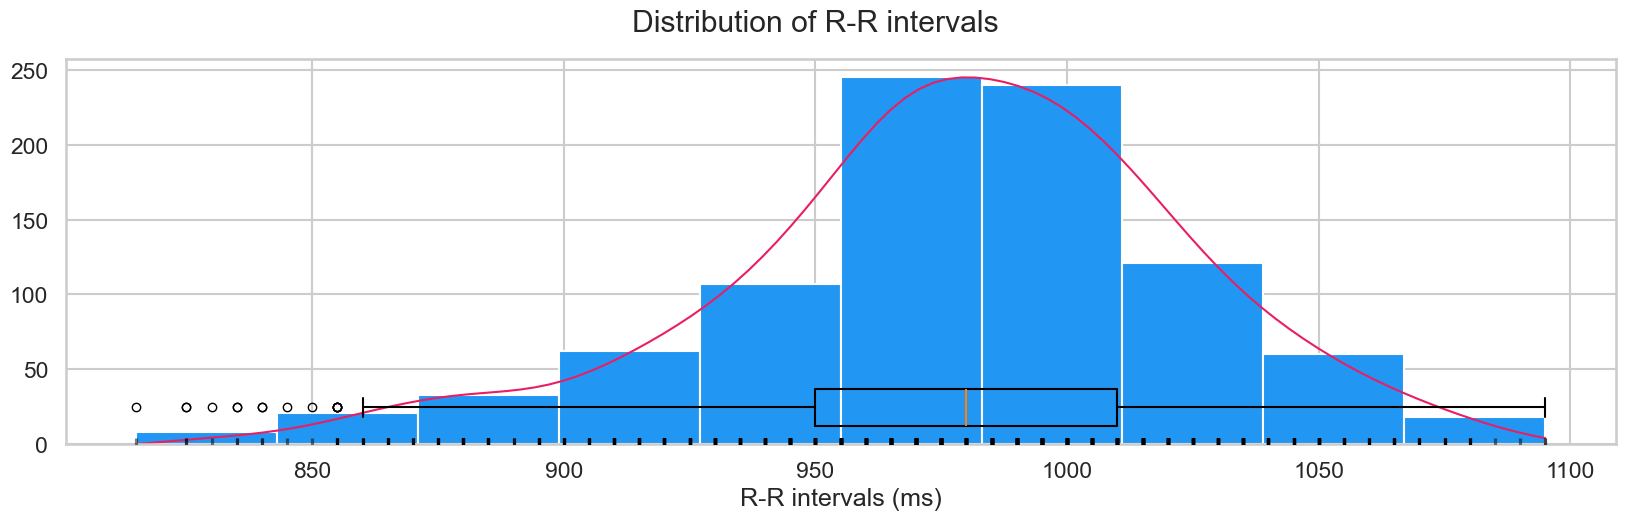

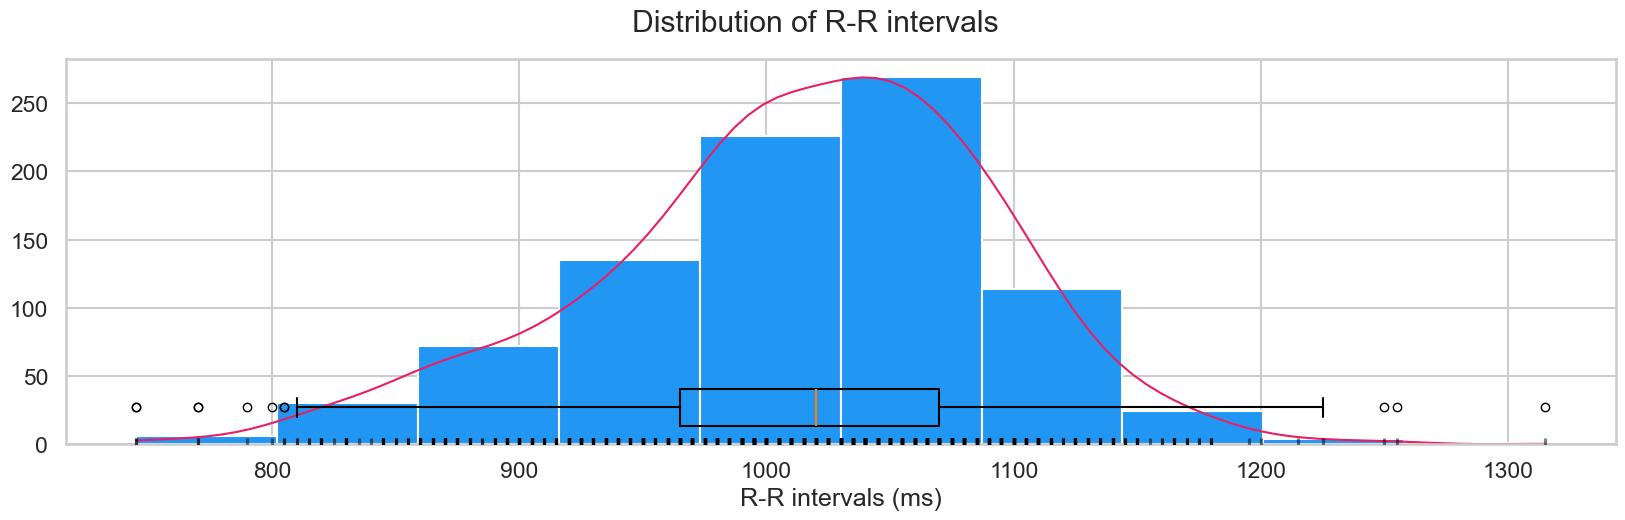

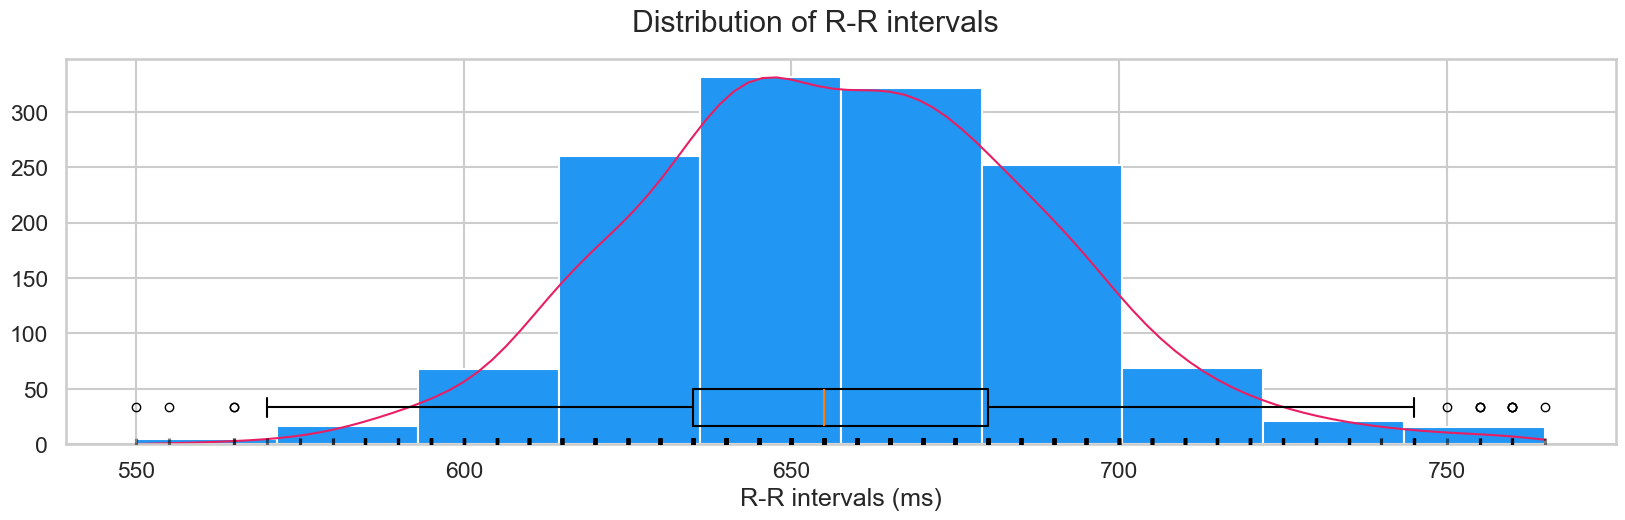

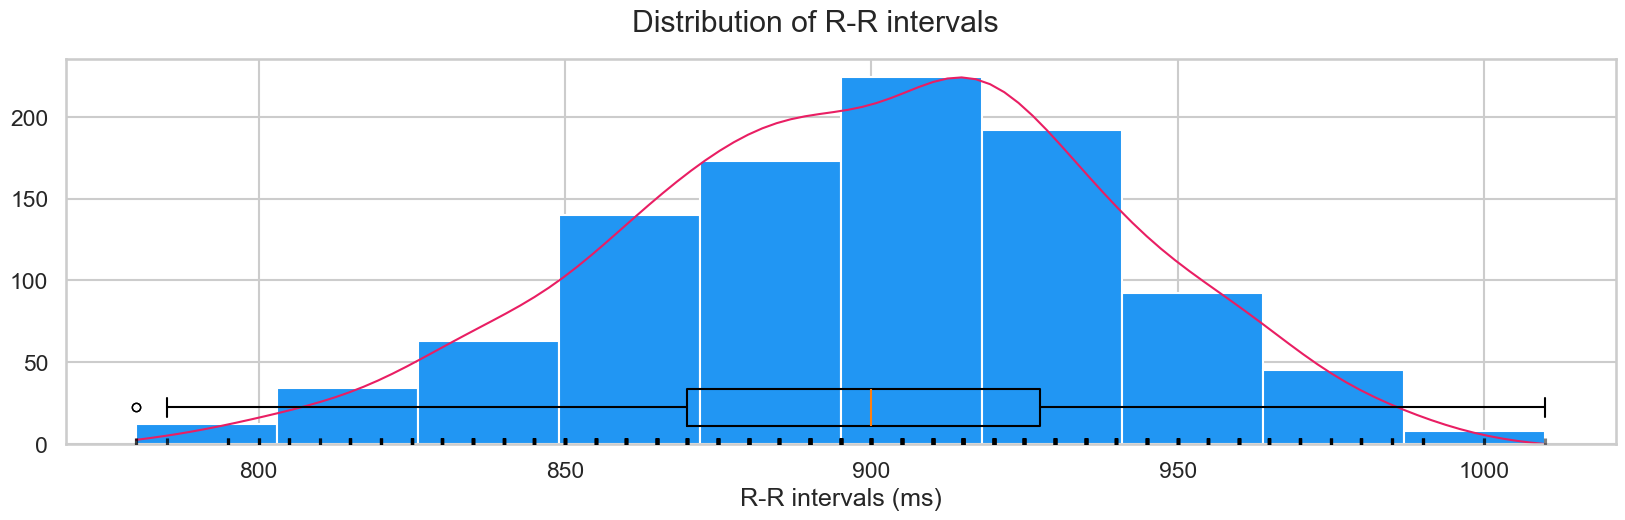

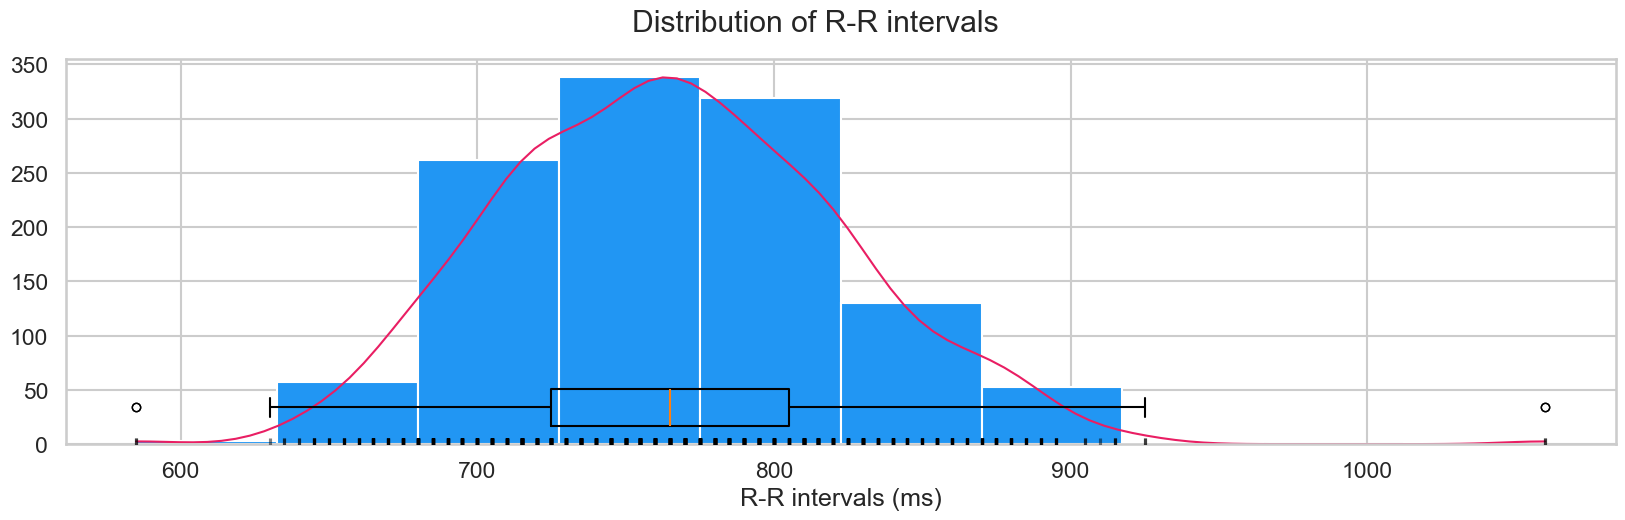

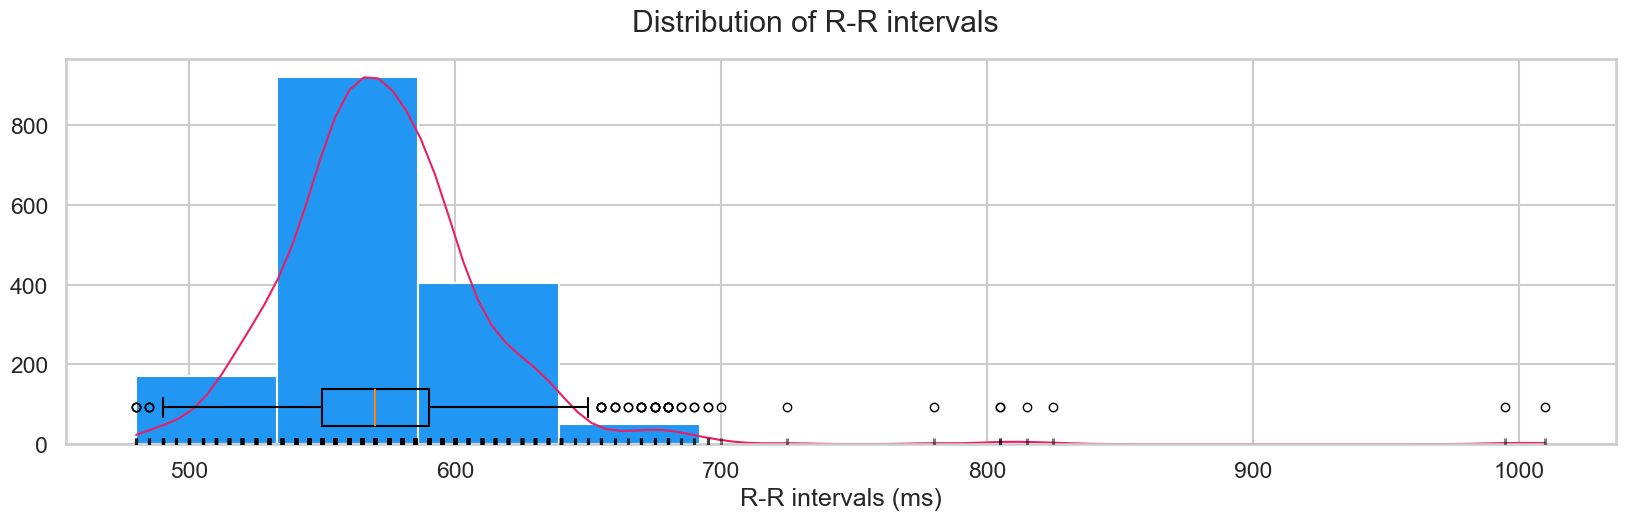

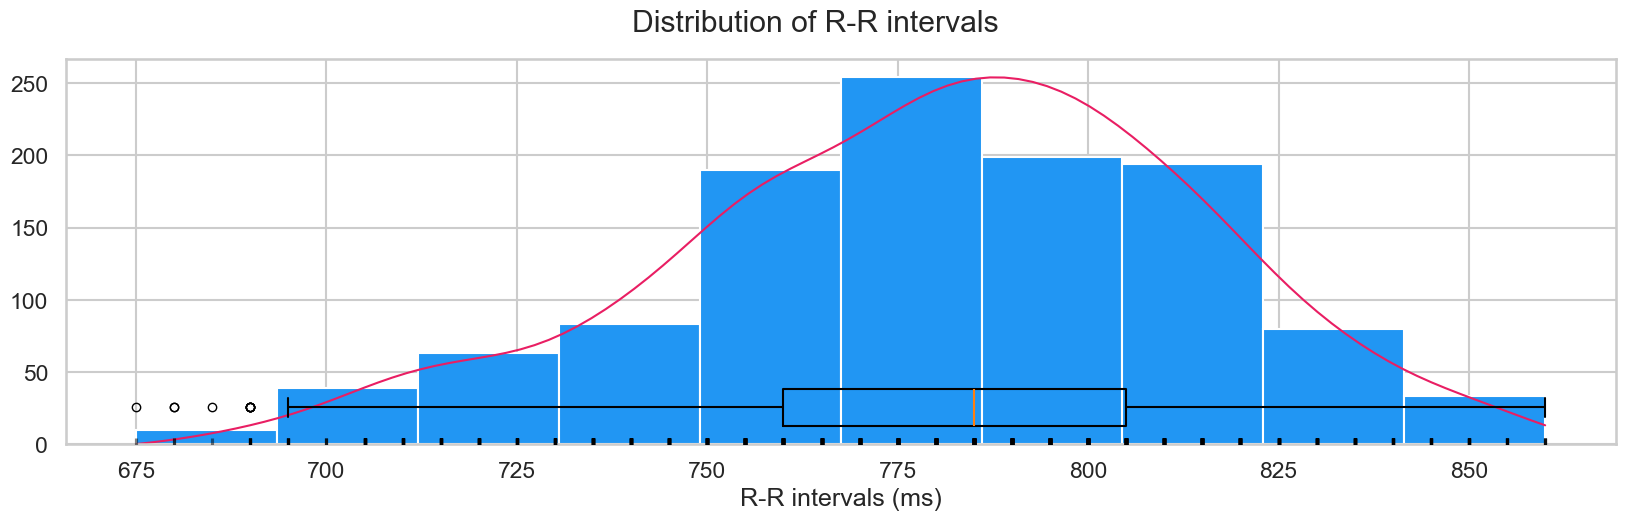

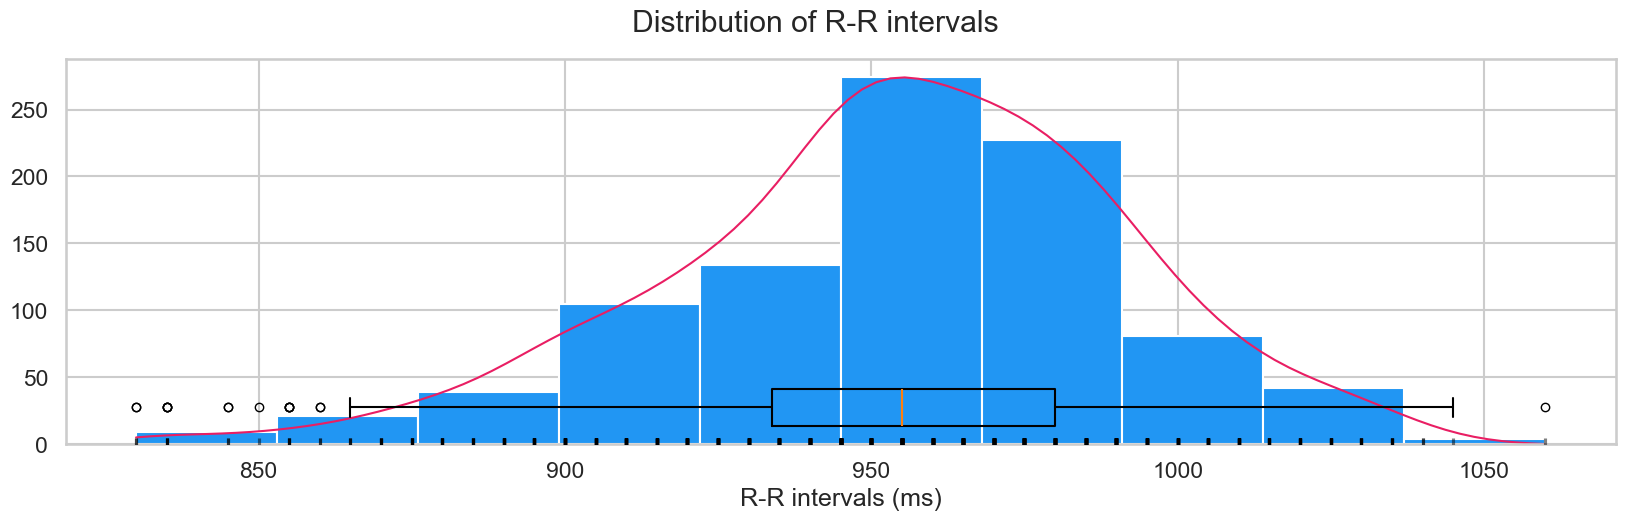

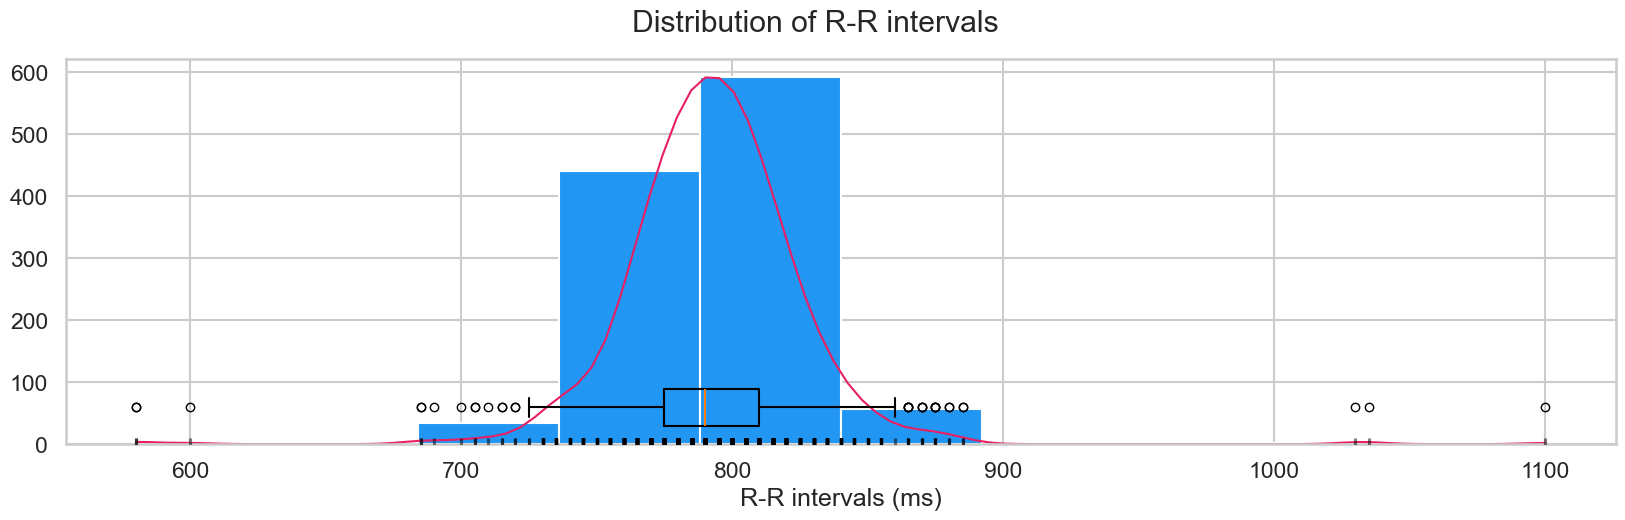

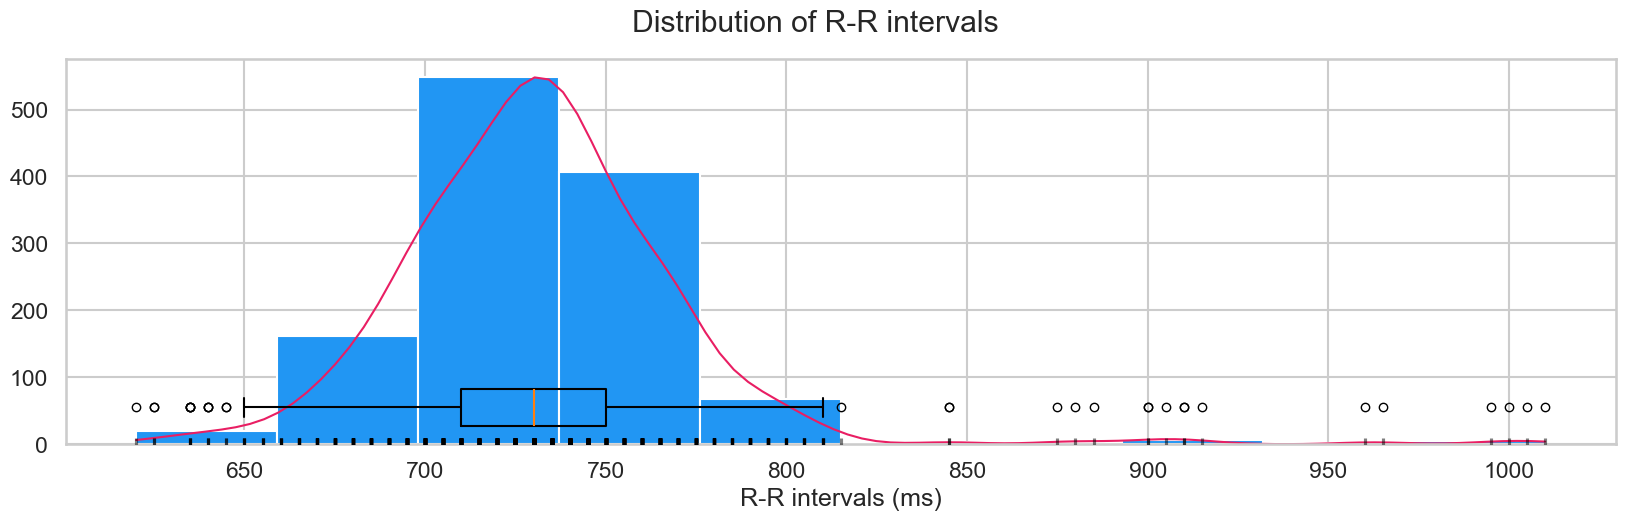

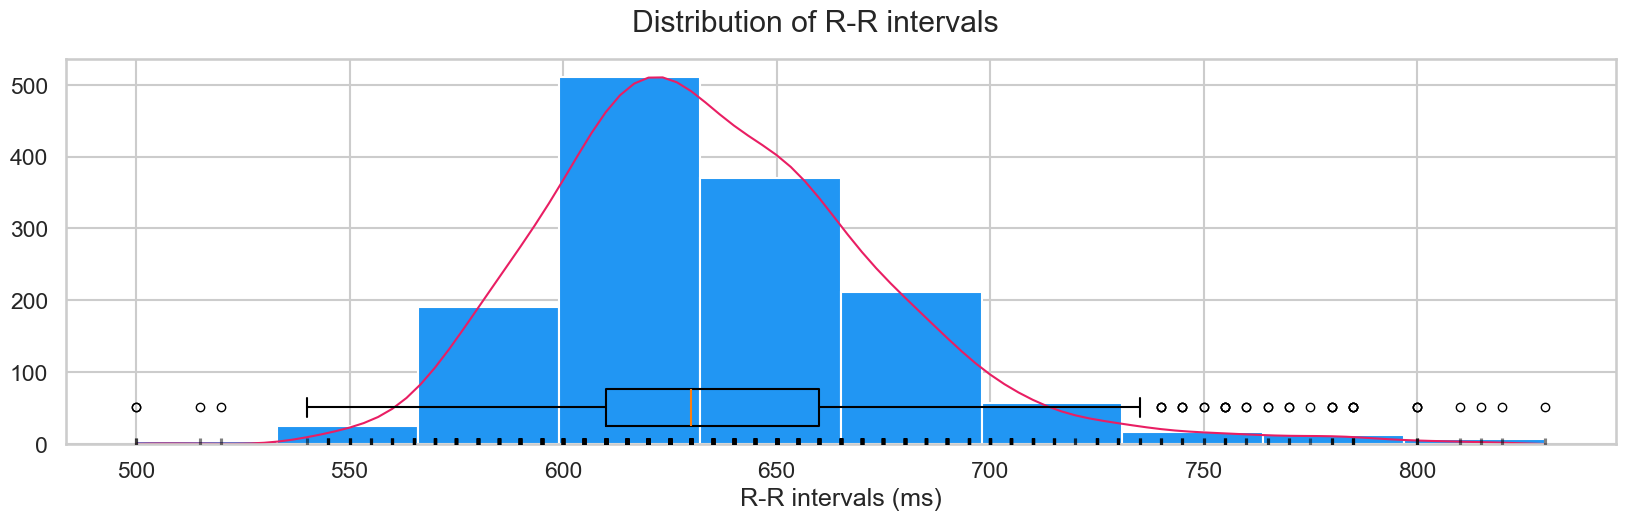

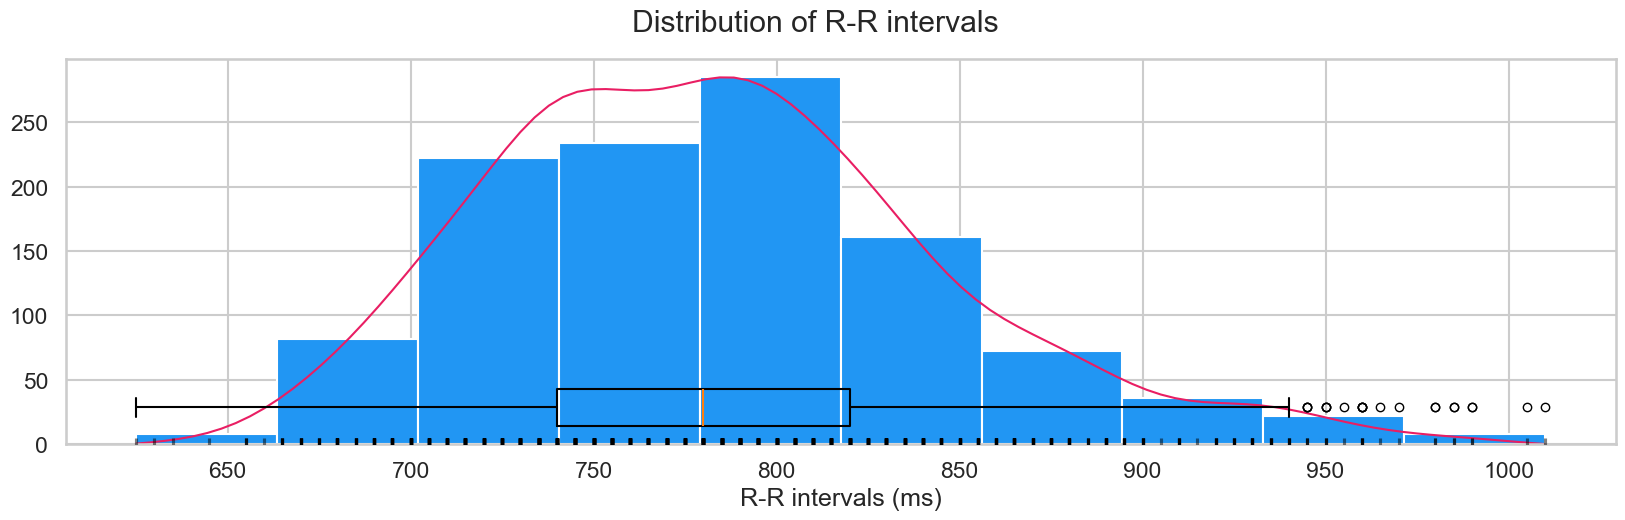

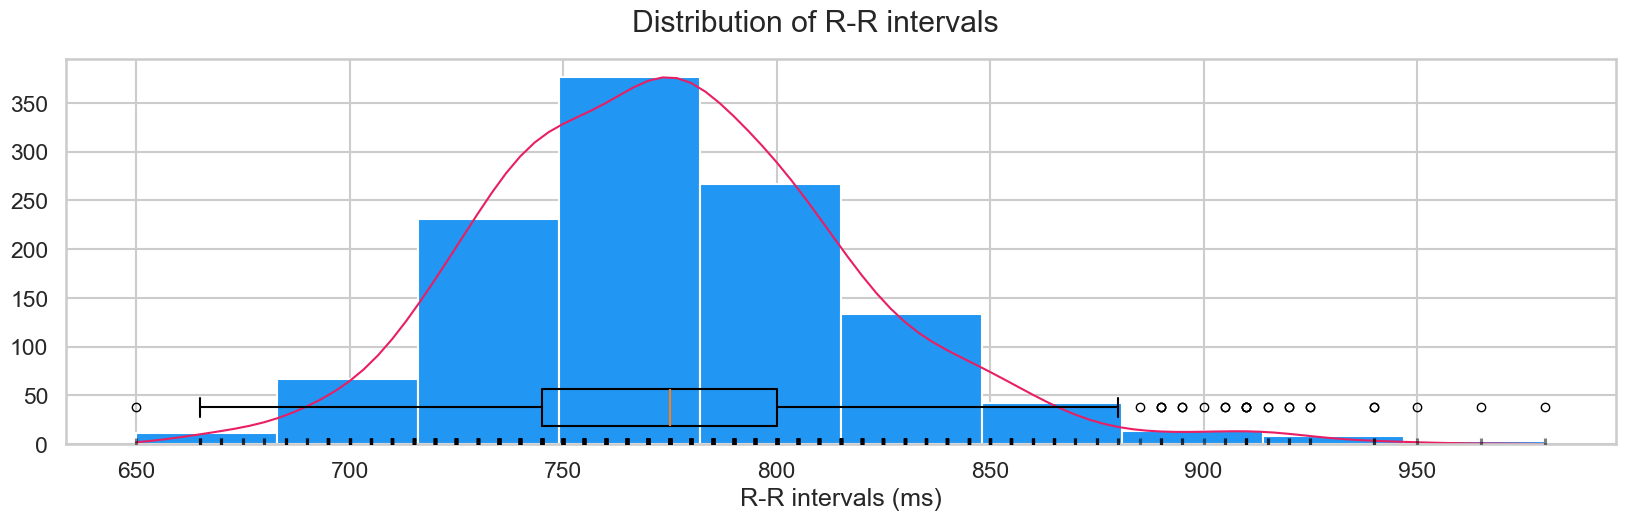

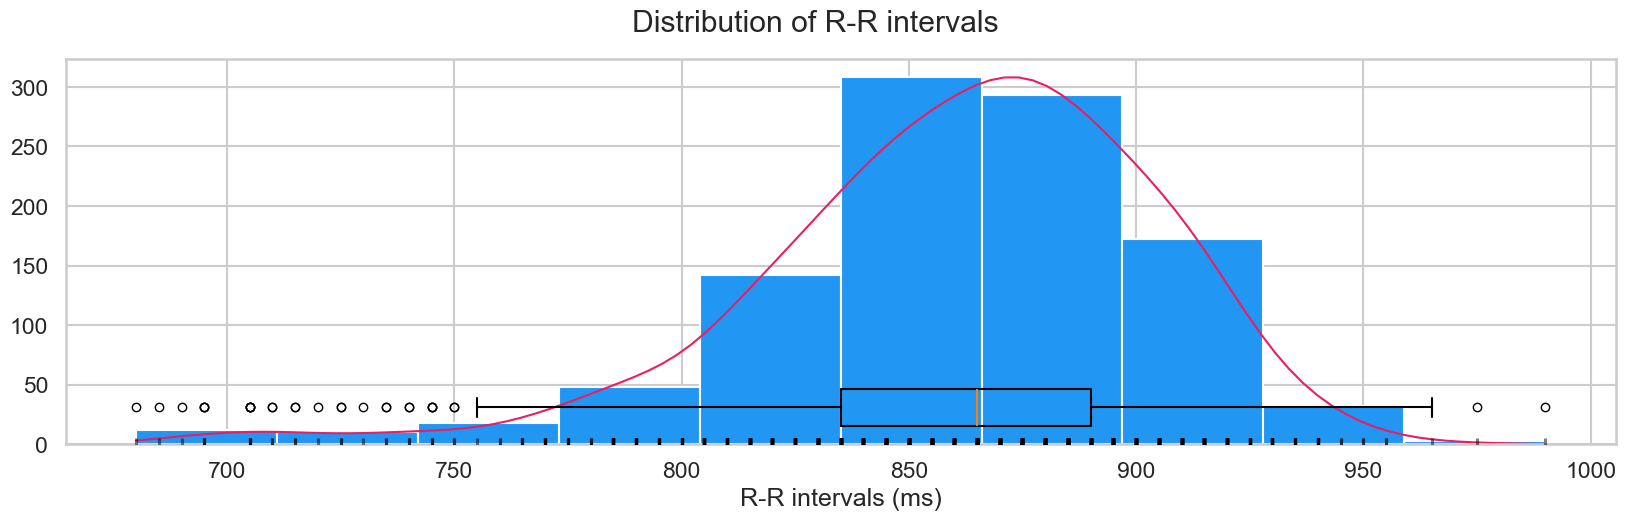

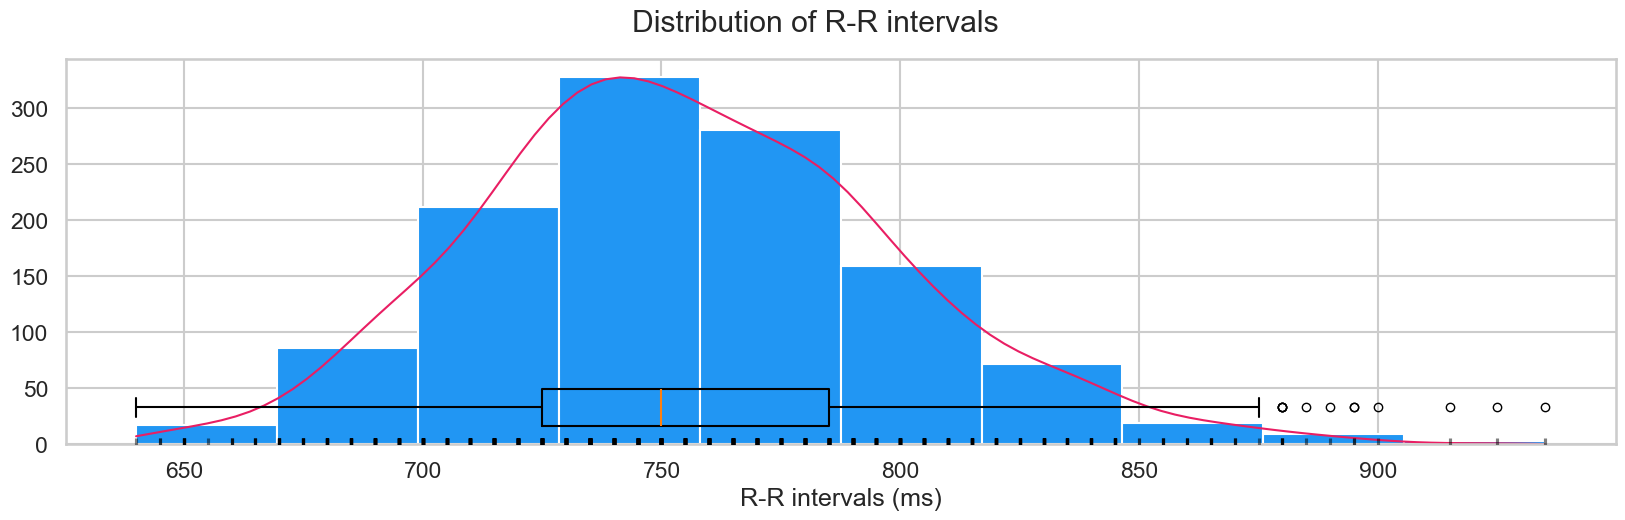

In [40]:
hrv_df_full = pd.DataFrame()

for pid in data_full.Participant.unique():
    peaks, info = nk.ecg_peaks(data_full.query('Participant == @pid').filtered_marimo_ECG, sampling_rate=sampling_rate, correct_artifacts=True)
    hrv = nk.hrv_time(peaks, sampling_rate=sampling_rate, show=True)
    hrv['Participant'] = pid
    hrv_df_full = pd.concat([hrv_df_full, hrv], ignore_index=True)


In [ ]:
# hrv_df_full.to_csv('hrv_df_full.csv', index=False)

In [37]:
hrv_df_full

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN,Participant
0,977.087432,47.448152,25.511695,39.917817,22.271412,42.144113,17.011608,45.431840,27.543977,27.559044,...,1.722633,945.0,1015.0,4.590164,37.486339,815.0,1095.0,9.150000,0.0000,C1K4L9S8
1,1012.826334,80.474533,33.266538,72.078818,27.879241,75.093160,16.261462,79.068867,70.215779,70.255707,...,1.146103,950.0,1080.0,45.516459,74.574347,745.0,1315.0,16.314815,296.8750,D0P7X9W6
2,658.030191,31.831305,15.093582,27.894476,12.643354,29.575384,9.290988,30.711374,14.648925,14.654326,...,2.172945,630.0,685.0,0.368189,11.708395,550.0,765.0,8.180723,0.0000,G9K4W1Z0
3,899.231943,40.906793,24.920288,32.949925,23.332065,34.948407,18.923480,37.945671,33.041664,33.058343,...,1.238037,865.0,935.0,7.324517,65.208545,780.0,1010.0,8.776786,140.6250,I8L4N6G7
4,765.836192,57.778694,25.159511,51.656348,23.608841,53.848567,14.593596,56.637999,53.257613,53.280484,...,1.084891,715.0,815.0,32.933105,69.811321,585.0,1060.0,14.219512,281.2500,J6W7Q4H5
5,573.613607,39.580778,27.815312,25.106283,22.200125,28.816158,14.548270,36.726901,16.762250,16.767635,...,2.361305,545.0,595.0,0.706033,3.851091,480.0,1010.0,7.637255,0.0000,K4G7Y9O2
6,780.043668,34.894920,23.943361,25.939103,22.072155,27.127344,7.268951,34.011425,12.053204,12.058424,...,2.895074,750.0,810.0,0.000000,5.414847,675.0,860.0,8.674242,156.2500,L0S1Z2I3
7,954.316239,37.453178,20.634647,30.683076,19.863540,31.314094,20.596946,32.713187,21.967404,21.979137,...,1.704943,925.0,985.0,2.350427,27.777778,830.0,1060.0,8.509091,125.0000,M4H6R2W9
8,792.772848,32.695102,14.666148,27.772913,9.132196,26.735953,9.790114,31.653621,30.738397,30.751951,...,1.063657,770.0,815.0,3.815439,40.195209,580.0,1100.0,6.789157,0.0000,M7D3F5K4
9,731.986077,39.279982,11.241634,35.651844,8.363084,38.201505,1.755085,38.831661,27.323202,27.334376,...,1.437605,705.0,755.0,2.620803,27.846028,620.0,1010.0,7.679245,0.0000,N7P5B8G0


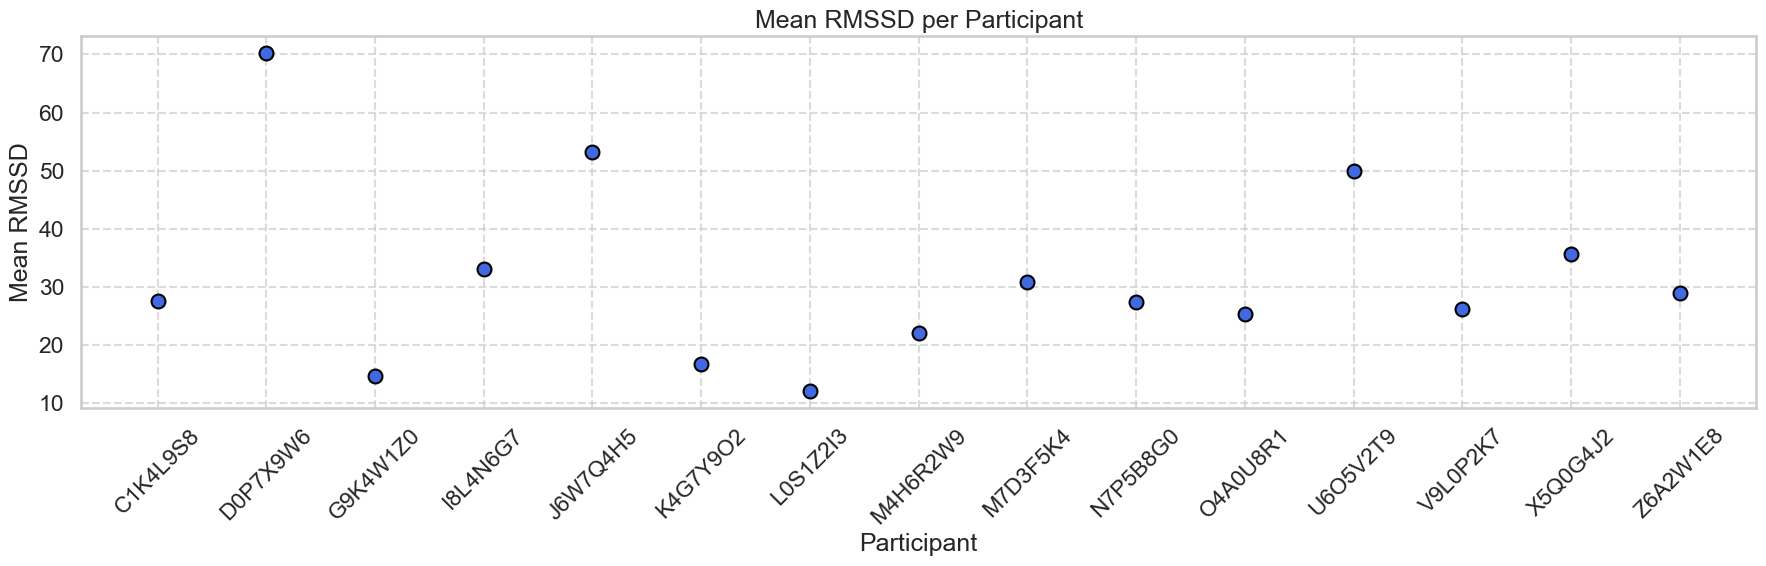

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")  # options: "darkgrid", "white", "ticks", etc.
sns.set_context("talk")     # larger font sizes: "notebook", "talk", "poster", etc.

# Create figure and plot
plt.figure(figsize=(18, 6))
plt.scatter(hrv_df_full['Participant'], hrv_df_full['HRV_RMSSD'], color='royalblue', s=100, edgecolor='black')

# Add grid and improve layout
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.xlabel("Participant", fontsize=18)
plt.ylabel("Mean RMSSD", fontsize=18)
plt.title("Mean RMSSD per Participant", fontsize=18)

plt.tight_layout()

plt.show()


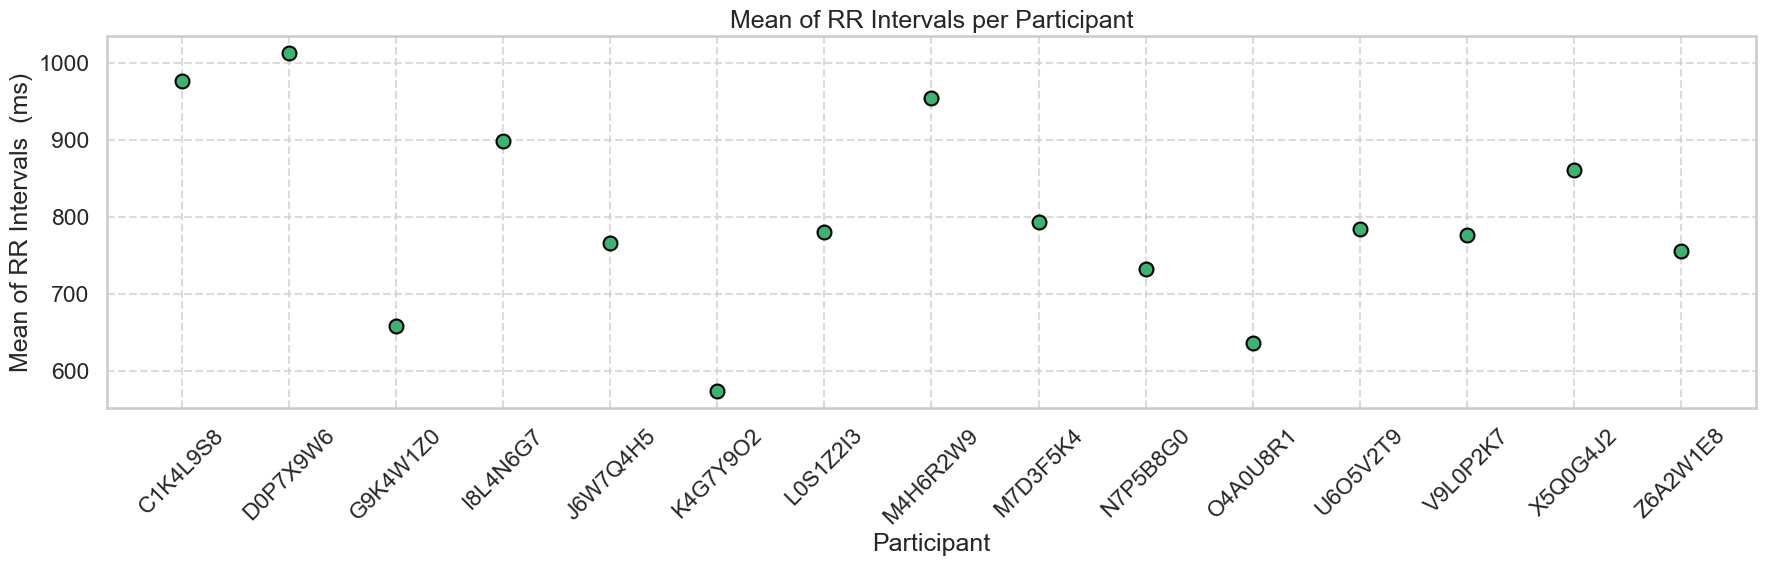

In [50]:
plt.figure(figsize=(18, 6))
plt.scatter(hrv_df_full['Participant'], hrv_df_full['HRV_MeanNN'], 
            color='mediumseagreen', s=100, edgecolor='black')

# Axis labels and title
plt.xlabel("Participant", fontsize=18)
plt.ylabel("Mean of RR Intervals  (ms)", fontsize=18)
plt.title("Mean of RR Intervals per Participant", fontsize=18)

# Rotate x-axis labels and add grid
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

# Improve spacing
plt.tight_layout()

plt.show()


### Signal quality check

https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/ecg/ecg_quality.html

In [51]:
data_full.query('Participant == "I8L4N6G7"')

,Timestamp,Raw_EDA_biopac,Raw_ECG_biopac,EventLabel,Participant,filtered_marimo_ECG,filtered_marimo_EDA
1100,16045.0005,1.145630,-0.227661,first_silence,I8L4N6G7,-0.074635,0.196013
1101,16050.0005,1.145630,-0.209045,first_silence,I8L4N6G7,-0.078590,0.195612
1102,16055.0005,1.145325,-0.166931,first_silence,I8L4N6G7,-0.081474,0.195210
1103,16060.0005,1.145325,-0.129700,first_silence,I8L4N6G7,-0.083035,0.194807
1104,16065.0005,1.145935,-0.147400,first_silence,I8L4N6G7,-0.084239,0.194417
...,...,...,...,...,...,...,...
178041,900750.0005,0.631409,-0.134277,last_silence,I8L4N6G7,0.075560,-0.002088
178042,900755.0005,0.631104,-0.187988,last_silence,I8L4N6G7,0.068507,-0.002092
178043,900760.0005,0.632019,-0.231934,last_silence,I8L4N6G7,0.060171,-0.002086
178044,900765.0005,0.631409,-0.271912,last_silence,I8L4N6G7,0.050805,-0.002076


In [52]:
d = []

for pid in data_full.Participant.unique():
    s = data_full.query('Participant == @pid').filtered_marimo_ECG
    quality = nk.ecg_quality(s, sampling_rate=sampling_rate)
    d_new = {'Participant':[pid]*len(quality), 'quality':quality}
    d.append(d_new)

df = pd.DataFrame(d)  
df_exploded = df.explode(['Participant', 'quality']).reset_index(drop=True)

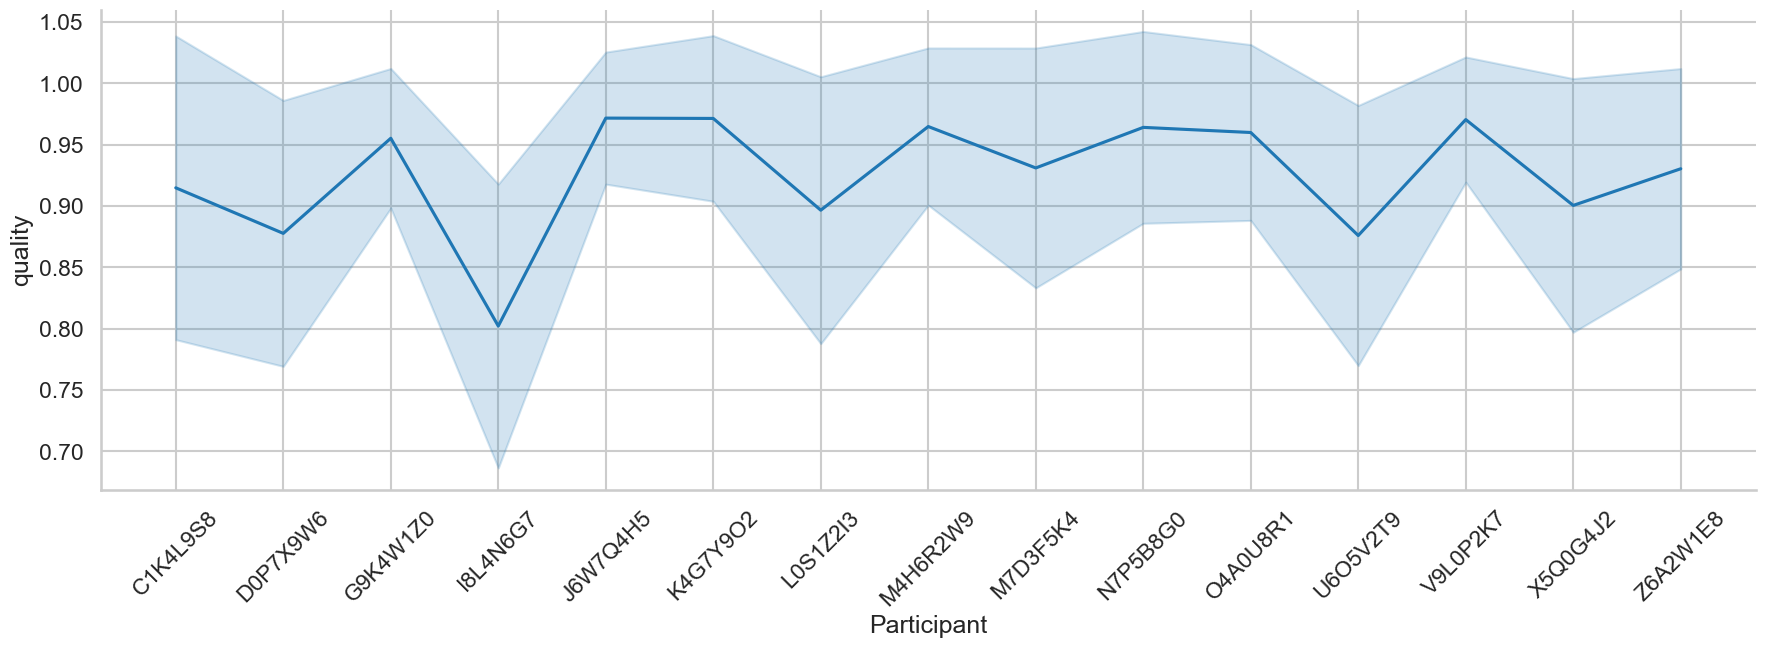

In [53]:
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

sns.relplot(data=df_exploded, x="Participant", y="quality", kind="line", errorbar='sd', height=6, aspect=3 )
plt.xticks(rotation=45)
plt.show()

### Statistical tests

In [ ]:
# THIS CODE IS FOR SEGMENTS WITHOUT OVERLAP



# def get_slope_for_condition(ecg, segment_duration):
    
#     peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate, correct_artifacts=True)
#     r_peaks = info['ECG_R_Peaks']
#     #segment_duration = 60  # For 1-minute segments (use 30 for 30-second segments)

#     # Step 1: Convert R-peak indices to time (seconds)
#     times = np.array(r_peaks) / sampling_rate

#     # Step 2: Calculate RR intervals (in milliseconds)
#     rr_intervals = np.diff(times) * 1000  # Difference in seconds, then convert to ms

#     # Step 3: Segment the data
#     total_duration = times[-1]  # Total experiment time in seconds
#     num_segments = int(np.floor(total_duration / segment_duration))
#     # print(total_duration, num_segments)

#     rmssd_per_segment = []
#     time_list = []

#     for seg in range(num_segments):
#         # Define the time window for this segment
#         start_time = seg * segment_duration
#         end_time = (seg + 1) * segment_duration
        
#         # Find R-peaks within this time window
#         mask = (times[:-1] >= start_time) & (times[:-1] < end_time)
#         segment_rr = rr_intervals[mask]
        
#         # Step 4: Calculate RMSSD for this segment
#         successive_diffs = np.diff(segment_rr)
#         squared_diffs = successive_diffs ** 2
#         mean_squared_diffs = np.mean(squared_diffs)
#         rmssd = np.sqrt(mean_squared_diffs)
#         rmssd_per_segment.append(rmssd)
#         time_list.append(end_time)
    
#     # print(len(time_list), len(rmssd_per_segment))
#     #rmssd_df = pd.DataFrame({'Time': time_list, 'RMSSD': rmssd_per_segment})
#     #rmssd_df['Time_str'] = rmssd_df['Time'].apply(lambda x: str(timedelta(seconds=x)))

#     X = sm.add_constant(time_list)
#     model = sm.OLS(rmssd_per_segment, X).fit()
#     slope = model.params[1]

#     return slope

In [42]:
# # check if my functions works, check with nk.hrv_time()['HRV_RMSSD']

# ecg = data_full.query('Participant == "M7D3F5K4"').filtered_marimo_ECG
# segment_duration = 893

# peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate, correct_artifacts=True)
# r_peaks = info['ECG_R_Peaks']
# #segment_duration = 60  # For 1-minute segments (use 30 for 30-second segments)

# # Step 1: Convert R-peak indices to time (seconds)
# times = np.array(r_peaks) / sampling_rate

# # Step 2: Calculate RR intervals (in milliseconds)
# rr_intervals = np.diff(times) * 1000  # Difference in seconds, then convert to ms

# # Step 3: Segment the data
# total_duration = times[-1]  # Total experiment time in seconds


# num_segments = int(np.floor(total_duration / segment_duration))

# rmssd_per_segment = []
# time_list = []

# for seg in range(num_segments):
#     # Define the time window for this segment
#     start_time = seg * segment_duration
#     end_time = (seg + 1) * segment_duration
    
#     # Find R-peaks within this time window
#     mask = (times[:-1] >= start_time) & (times[:-1] < end_time)
#     segment_rr = rr_intervals[mask]
    
#     # Step 4: Calculate RMSSD for this segment
#     successive_diffs = np.diff(segment_rr)
#     squared_diffs = successive_diffs ** 2
#     mean_squared_diffs = np.mean(squared_diffs)
#     rmssd = np.sqrt(mean_squared_diffs)
#     rmssd_per_segment.append(rmssd)
#     time_list.append(end_time)

# peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate, correct_artifacts=True)
# hrv = nk.hrv_time(peaks, sampling_rate=sampling_rate)


# assert round(rmssd_per_segment[0]) == round(hrv['HRV_RMSSD'].values[0])
# # values typically range from 20-50 milliseconds for healthy adults
# print(round(rmssd_per_segment[0],1))

30.8


In [ ]:
# Add overlap to segments

In [20]:
def get_slope_for_condition(ecg, segment_duration = 30, overlap_duration = 10):
    
    step_size = segment_duration - overlap_duration  # 20 seconds

    peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate, correct_artifacts=True)
    r_peaks = info['ECG_R_Peaks']

    # Step 1: Convert R-peak indices to time (seconds)
    times = np.array(r_peaks) / sampling_rate

    # Step 2: Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(times) * 1000  # Difference in seconds, then convert to ms

    # Step 3: Segment the data with overlap
    total_duration = times[-1]  # Total experiment time in seconds
    num_segments = int(np.floor((total_duration - segment_duration) / step_size)) + 1

    rmssd_per_segment = []
    time_list = []

    for seg in range(num_segments):
        # Define the time window for this segment
        start_time = seg * step_size
        end_time = start_time + segment_duration
        
        # Find R-peaks within this time window
        mask = (times[:-1] >= start_time) & (times[:-1] < end_time)
        segment_rr = rr_intervals[mask]
        
        # Step 4: Calculate RMSSD for this segment
        successive_diffs = np.diff(segment_rr)
        squared_diffs = successive_diffs ** 2
        mean_squared_diffs = np.mean(squared_diffs)
        rmssd = np.sqrt(mean_squared_diffs)
        rmssd_per_segment.append(rmssd)
        time_list.append(end_time)
        

    X = sm.add_constant(time_list)
    model = sm.OLS(rmssd_per_segment, X).fit()
    slope = model.params[1]
    return slope

In [21]:
positives_slopes = [get_slope_for_condition(data.filtered_marimo_ECG) for participant_id, data in positives.groupby(by='Participant')]
negatives_slopes = [get_slope_for_condition(data.filtered_marimo_ECG) for participant_id, data in negatives.groupby(by='Participant')]
baselines_slopes_fisrt = [get_slope_for_condition(data.filtered_marimo_ECG) for participant_id, data in baselines_first.groupby(by='Participant')]
baselines_slopes_last = [get_slope_for_condition(data.filtered_marimo_ECG) for participant_id, data in baselines_last.groupby(by='Participant')]

In [22]:

t = [i for i, _  in positives.groupby(by='Participant')]


df_long = pd.DataFrame({
    "Participant": t * 4,
    "Slope": list(positives_slopes) + list(negatives_slopes) + list(baselines_slopes_fisrt) + list(baselines_slopes_last),
    "Condition": ["Positive podcast"] * len(t) + ["Negative podcast"] * len(t) + ["Baseline silence"] * len(t) + ["Cool down phase"] * len(t)
})


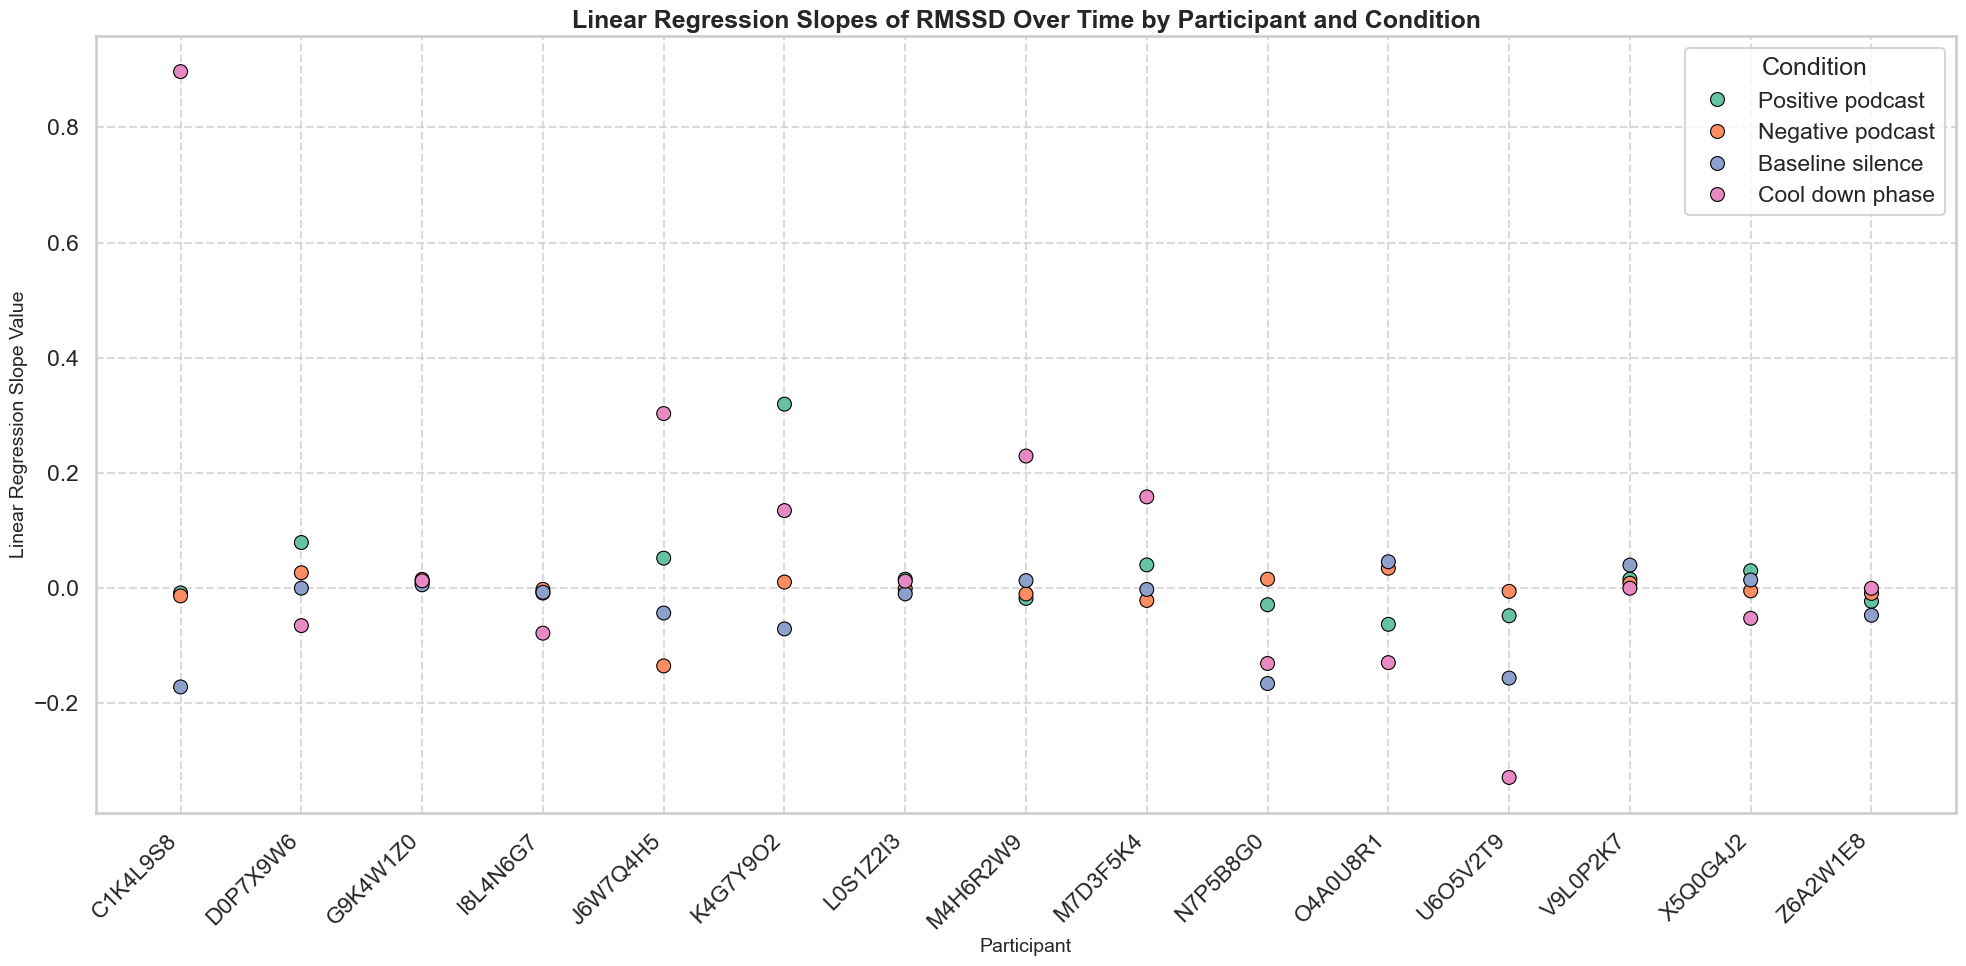

In [25]:
sns.set_style("whitegrid")
sns.set_context("talk")  


plt.figure(figsize=(20, 10))


sns.scatterplot(
    data=df_long,
    x="Participant",
    y="Slope",
    hue="Condition",
    s=100,  # size of dots
    palette="Set2",  # or "colorblind", "deep", etc.
    edgecolor='black'
)


plt.title("Linear Regression Slopes of RMSSD Over Time by Participant and Condition", fontsize=18, weight='bold')
plt.xlabel("Participant", fontsize=14)
plt.ylabel("Linear Regression Slope Value", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [67]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6] 


np.random.seed(42)  # For reproducibility
data = {
    'Baseline silence': baselines_slopes_fisrt,  
    'Cool down phase': baselines_slopes_last,  
    'Positive podcast': positives_slopes,
    'Negative podcast': negatives_slopes
}
df = pd.DataFrame(data)


# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

print()


conditions = df.columns
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        cond1, cond2 = conditions[i], conditions[j]
        stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
        print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}")


Shapiro-Wilk test for Cool down phase: statistic=0.817, p=0.006
  Cool down phase is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive podcast: statistic=0.695, p=0.000
  Positive podcast is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative podcast: statistic=0.674, p=0.000
  Negative podcast is not normally distributed (p < 0.05)

Wilcoxon Baseline silence vs Cool down phase: statistic=46.000, p=0.454
Wilcoxon Baseline silence vs Positive podcast: statistic=25.000, p=0.048
Wilcoxon Baseline silence vs Negative podcast: statistic=43.000, p=0.359
Wilcoxon Cool down phase vs Positive podcast: statistic=54.000, p=0.762
Wilcoxon Cool down phase vs Negative podcast: statistic=53.000, p=0.720
Wilcoxon Positive podcast vs Negative podcast: statistic=48.000, p=0.524


In [54]:
# Now lets compute p values on just rmssd values 

/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_23013/1019515384.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Slope', data=df_long, palette=palette, width=0.5)


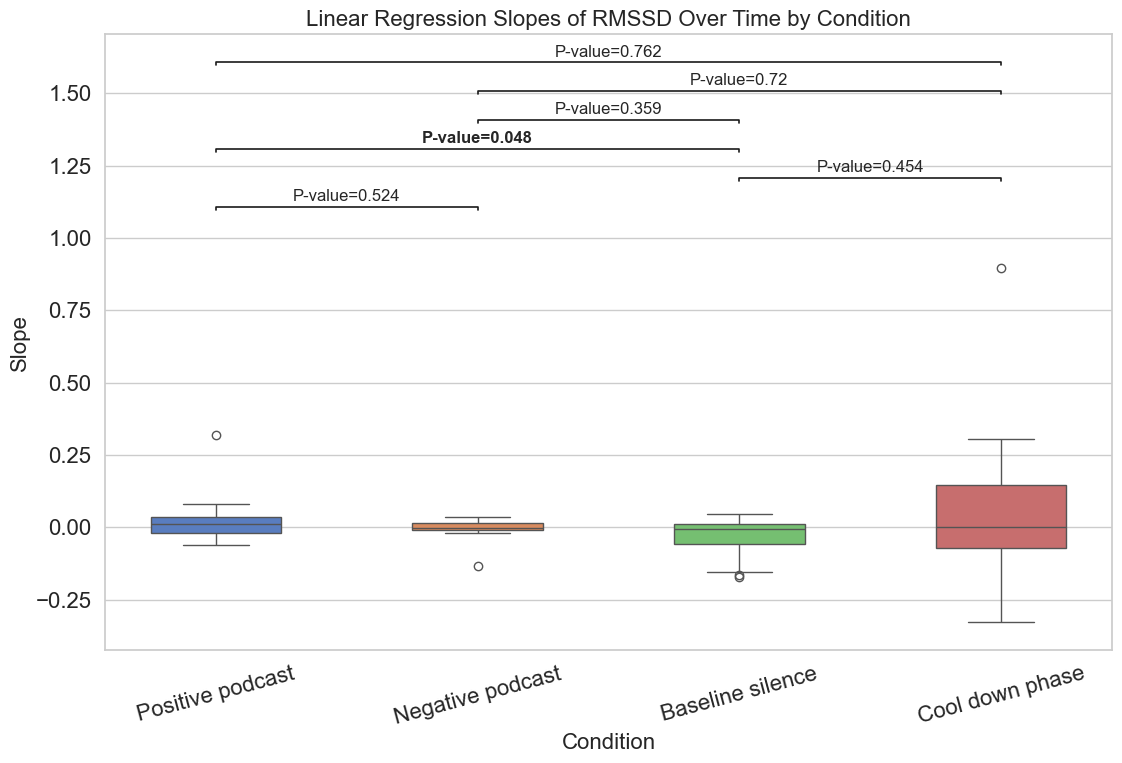

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

# Define custom colors
palette = sns.color_palette("muted", 4)  # or "muted", "pastel", "deep", etc.
plt.figure(figsize=(13, 8))
sns.boxplot(x='Condition', y='Slope', data=df_long, palette=palette, width=0.5)

comparisons = [
    ('Positive podcast', 'Negative podcast'),
    ('Baseline silence', 'Cool down phase'),
    ('Baseline silence', 'Positive podcast'),
    ('Baseline silence', 'Negative podcast'),
    ('Cool down phase', 'Negative podcast'),
    ('Cool down phase', 'Positive podcast'),
]

x_labels = df_long['Condition'].unique().tolist()

y_offset = 0.1
y_start = df_long['Slope'].max() + 0.2
h = 0.01
fontsize = 12

for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # P-value annotation
    label = f'P-value={round(p_val, 3)}'
    if p_val < 0.05:    
        plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize, fontweight='bold')
    else:
        plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Linear Regression Slopes of RMSSD Over Time by Condition', fontsize=16)
plt.ylabel('Slope', fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.xticks(fontsize=16,rotation=15)
plt.yticks(fontsize=16)
plt.show()


## EDA biopac

In [95]:
sampling_rate = 200

### Some visualizations

In [97]:
plt.rcParams['figure.figsize'] = [20, 8] 

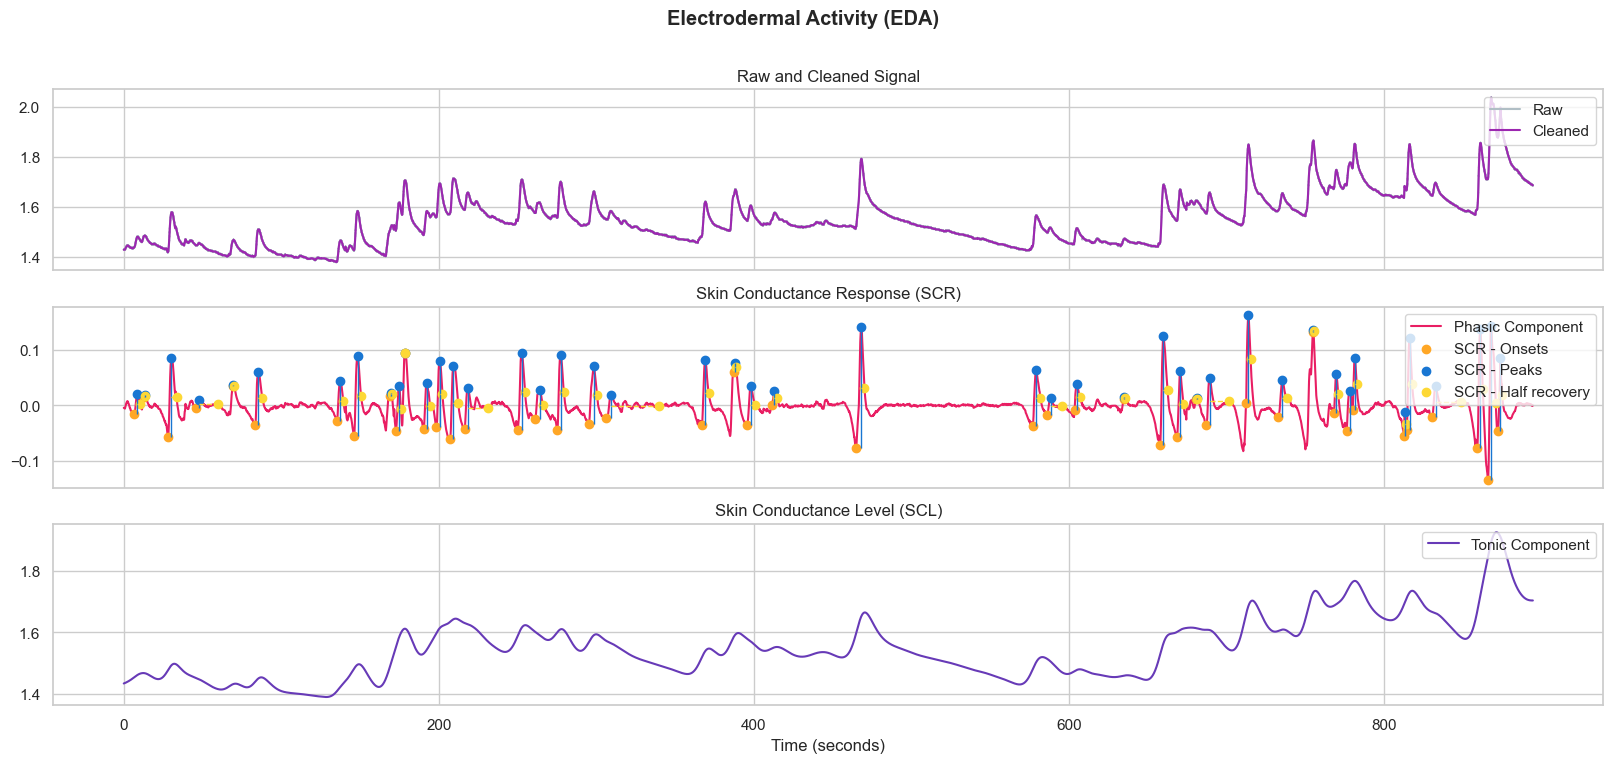

In [98]:
eda_signal = data_full.query('Participant == "C1K4L9S8"').Raw_EDA_biopac
signals, info = nk.eda_process(eda_signal, sampling_rate=sampling_rate)
nk.eda_plot(signals, info)

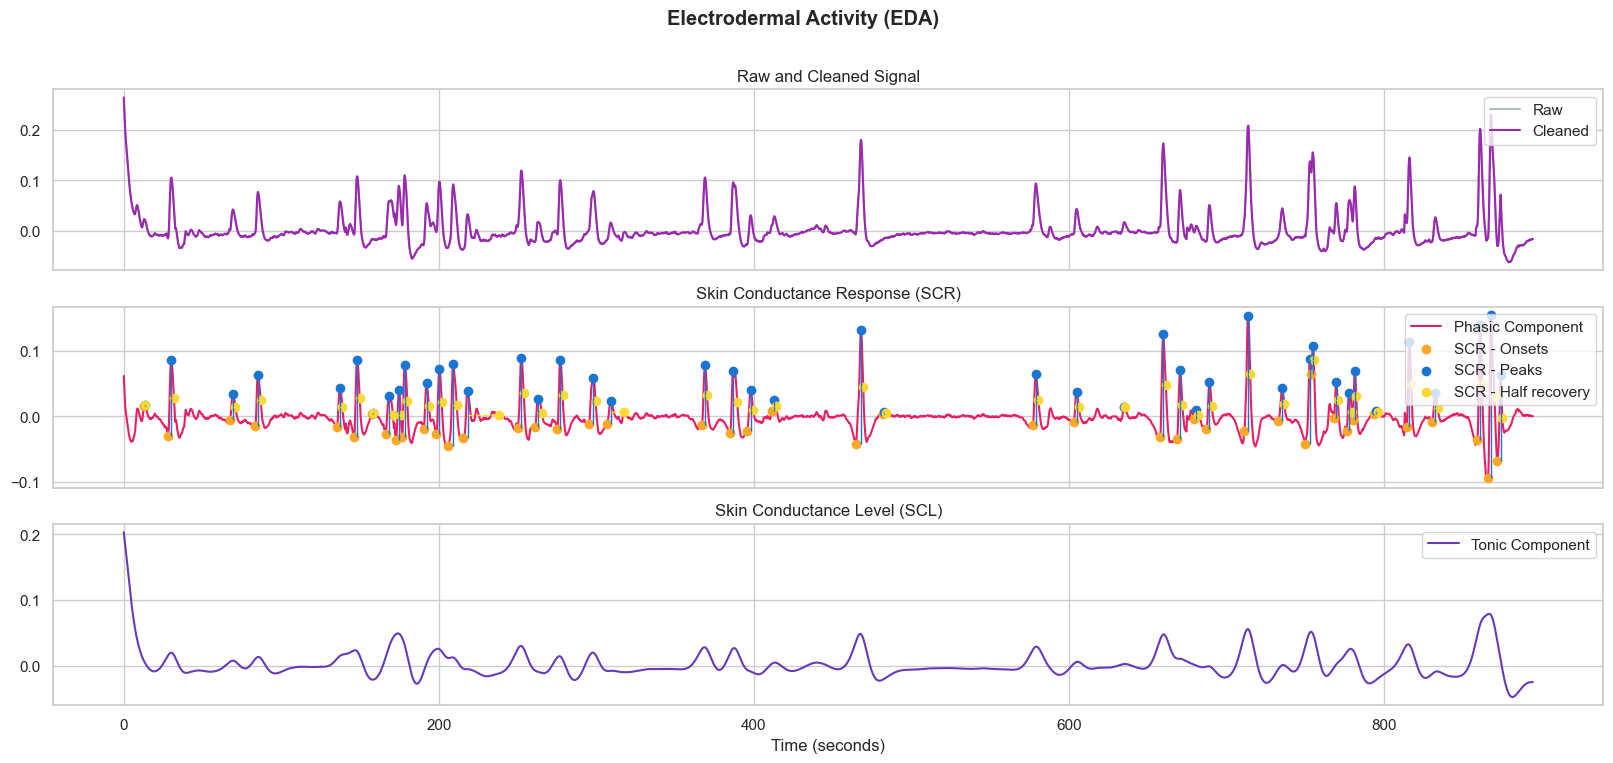

In [99]:
eda_signal = data_full.query('Participant == "C1K4L9S8"').filtered_marimo_EDA
signals, info = nk.eda_process(eda_signal, sampling_rate=sampling_rate)
nk.eda_plot(signals, info)

In [111]:
ecg_metrics = pd.DataFrame()

for participant, data in data_full.groupby(by='Participant'):
    signal, _= nk.eda_process(data.filtered_marimo_EDA, sampling_rate=sampling_rate)
    d = nk.eda_intervalrelated(signal, sampling_rate=sampling_rate)
    d['Participant'] = participant
    ecg_metrics = pd.concat([ecg_metrics, d], ignore_index=True)
    
ecg_metrics

,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Tonic_SD,EDA_Sympathetic,EDA_SympatheticN,EDA_Autocorrelation,Participant
0,45.0,0.080615,0.021237,0.000469,0.075092,0.018845,C1K4L9S8
1,20.0,0.109868,0.032535,0.000577,0.054597,0.209515,D0P7X9W6
2,74.0,0.298246,0.059108,0.009522,0.104094,-0.103273,G9K4W1Z0
3,12.0,0.032519,0.013316,0.000136,0.033600,0.243144,I8L4N6G7
4,12.0,0.023654,0.008235,0.000042,0.056243,0.225029,J6W7Q4H5
5,58.0,0.012323,0.017471,0.000057,0.035233,0.310843,K4G7Y9O2
6,128.0,0.214373,0.047487,0.008021,0.094536,-0.067320,L0S1Z2I3
7,27.0,0.012695,0.005248,0.000037,0.060434,0.087785,M4H6R2W9
8,68.0,0.057437,0.029763,0.000717,0.065638,0.061842,M7D3F5K4
9,56.0,0.129590,0.036558,0.001352,0.079865,0.088164,N7P5B8G0


In [112]:
ecg_metrics = pd.DataFrame()

for participant, data in data_full.groupby(by='Participant'):
    signal, _= nk.eda_process(data.Raw_EDA_biopac, sampling_rate=sampling_rate)
    d = nk.eda_intervalrelated(signal, sampling_rate=sampling_rate)
    d['Participant'] = participant
    ecg_metrics = pd.concat([ecg_metrics, d], ignore_index=True)

ecg_metrics

,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Tonic_SD,EDA_Sympathetic,EDA_SympatheticN,EDA_Autocorrelation,Participant
0,45.0,0.085481,0.098931,0.000647,0.005117,0.837312,C1K4L9S8
1,18.0,0.145322,0.145040,0.000852,0.004877,0.849973,D0P7X9W6
2,70.0,0.357069,0.170566,0.012703,0.020904,0.465369,G9K4W1Z0
3,11.0,0.054504,0.172902,0.000222,0.002494,0.977474,I8L4N6G7
4,13.0,0.021988,0.077556,0.000067,0.002276,0.955722,J6W7Q4H5
5,52.0,0.016782,0.032838,0.000087,0.000511,0.816268,K4G7Y9O2
6,123.0,0.246344,0.203537,0.010991,0.031482,0.647517,L0S1Z2I3
7,24.0,0.007194,0.027208,0.000056,0.007589,0.864387,M4H6R2W9
8,60.0,0.059830,0.135066,0.001096,0.003665,0.865995,M7D3F5K4
9,56.0,0.150796,0.175638,0.001794,0.004069,0.871957,N7P5B8G0


### Statistical tests

In [ ]:
# Normalize by minutes!!

In [116]:
result = data_full.groupby(['EventLabel', 'Participant'])['Timestamp'].agg(['count'])
result

count
EventLabel   Participant       
CalmAudio    C1K4L9S8     54338
             D0P7X9W6     54406
             G9K4W1Z0     54200
             I8L4N6G7     54418
             J6W7Q4H5     54335
...                         ...
last_silence O4A0U8R1     19156
             U6O5V2T9     17476
             V9L0P2K7     19159
             X5Q0G4J2     19147
             Z6A2W1E8     19600

[75 rows x 1 columns]

In [117]:
average_time = result.groupby('EventLabel')['count'].mean() / 200 / 60
average_time

EventLabel
CalmAudio        4.527556
IntenseAudio     4.541311
InterimAudio     0.829128
first_silence    3.399778
last_silence     1.590583
Name: count, dtype: float64

In [118]:
def extract_eda_info(df):
    n_peaks = []
    ampl_peaks = []

    for participant, data in df.groupby(by='Participant'):
        # signal, _= nk.eda_process(data.filtered_marimo_EDA, sampling_rate=sampling_rate)
        signal, _= nk.eda_process(data.Raw_EDA_biopac, sampling_rate=sampling_rate)
        d = nk.eda_intervalrelated(signal, sampling_rate=sampling_rate)
        n_peaks.append(d['SCR_Peaks_N'][0])
        ampl_peaks.append(d['SCR_Peaks_Amplitude_Mean'][0])

    return n_peaks,  ampl_peaks

n_peaks_pos, ampl_peaks_pos = extract_eda_info(positives)
n_peaks_neg, ampl_peaks_neg = extract_eda_info(negatives)
n_peaks_bas_1, ampl_peaks_bas_1 = extract_eda_info(baselines_first)
n_peaks_bas_2, ampl_peaks_bas_2 = extract_eda_info(baselines_last)

In [119]:
# Normalize by minutes!!
n_peaks_pos = np.array(n_peaks_pos)/average_time.CalmAudio
n_peaks_neg = np.array(n_peaks_neg)/average_time.IntenseAudio
n_peaks_bas_1 = np.array(n_peaks_bas_1)/average_time.first_silence
n_peaks_bas_2 = np.array(n_peaks_bas_2)/average_time.last_silence

#### Tests for number of peaks

In [138]:
t = [i for i, _  in positives.groupby(by='Participant')]

# Create a tidy DataFrame
df_long = pd.DataFrame({
    "Participant": t * 4,
    "Number of SCR peaks": list(n_peaks_pos) + list(n_peaks_neg) + list(n_peaks_bas_1) + list(n_peaks_bas_2),
    "Amplitude of SCR peaks": list(ampl_peaks_pos) + list(ampl_peaks_neg) + list(ampl_peaks_bas_1) + list(ampl_peaks_bas_2),
    "Condition": ["Positive podcast"] * len(t) + ["Negative podcast"] * len(t) + ["Baseline silence"] * len(t) + ["Cool down phase"] * len(t)
})

In [139]:
df_long

,Participant,Number of SCR peaks,Amplitude of SCR peaks,Condition
0,C1K4L9S8,3.092176,0.074378,Positive podcast
1,D0P7X9W6,1.325218,0.126745,Positive podcast
2,G9K4W1Z0,3.313046,0.373092,Positive podcast
3,I8L4N6G7,3.092176,0.003834,Positive podcast
4,J6W7Q4H5,1.325218,0.009552,Positive podcast
5,K4G7Y9O2,7.509571,0.004081,Positive podcast
6,L0S1Z2I3,10.601747,0.274220,Positive podcast
7,M4H6R2W9,3.754786,0.005319,Positive podcast
8,M7D3F5K4,3.975655,0.037442,Positive podcast
9,N7P5B8G0,4.859134,0.197647,Positive podcast


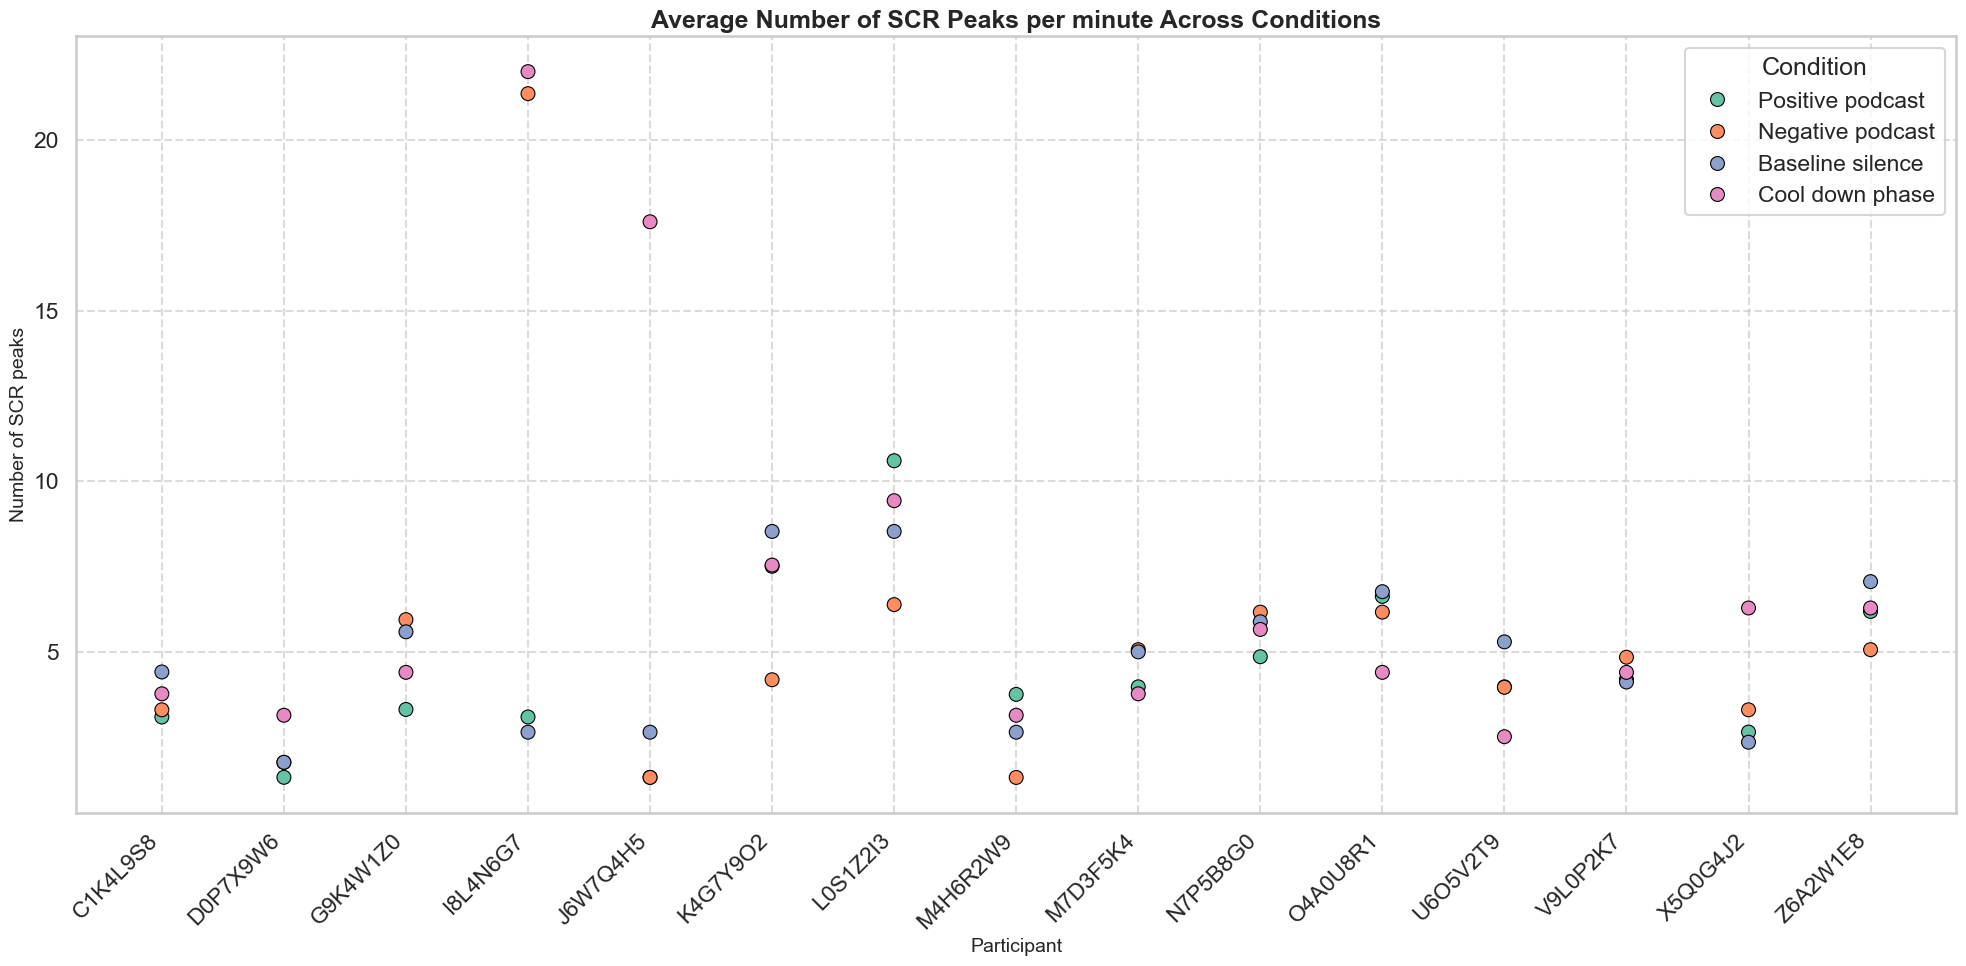

In [140]:
sns.set_style("whitegrid")
sns.set_context("talk")  


plt.figure(figsize=(20, 10))


sns.scatterplot(
    data=df_long,
    x="Participant",
    y="Number of SCR peaks",
    hue="Condition",
    s=100,  # size of dots
    palette="Set2",  # or "colorblind", "deep", etc.
    edgecolor='black'
)


plt.title("Average Number of SCR Peaks per minute Across Conditions", fontsize=18, weight='bold')
plt.xlabel("Participant", fontsize=14)
plt.ylabel("Number of SCR peaks", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


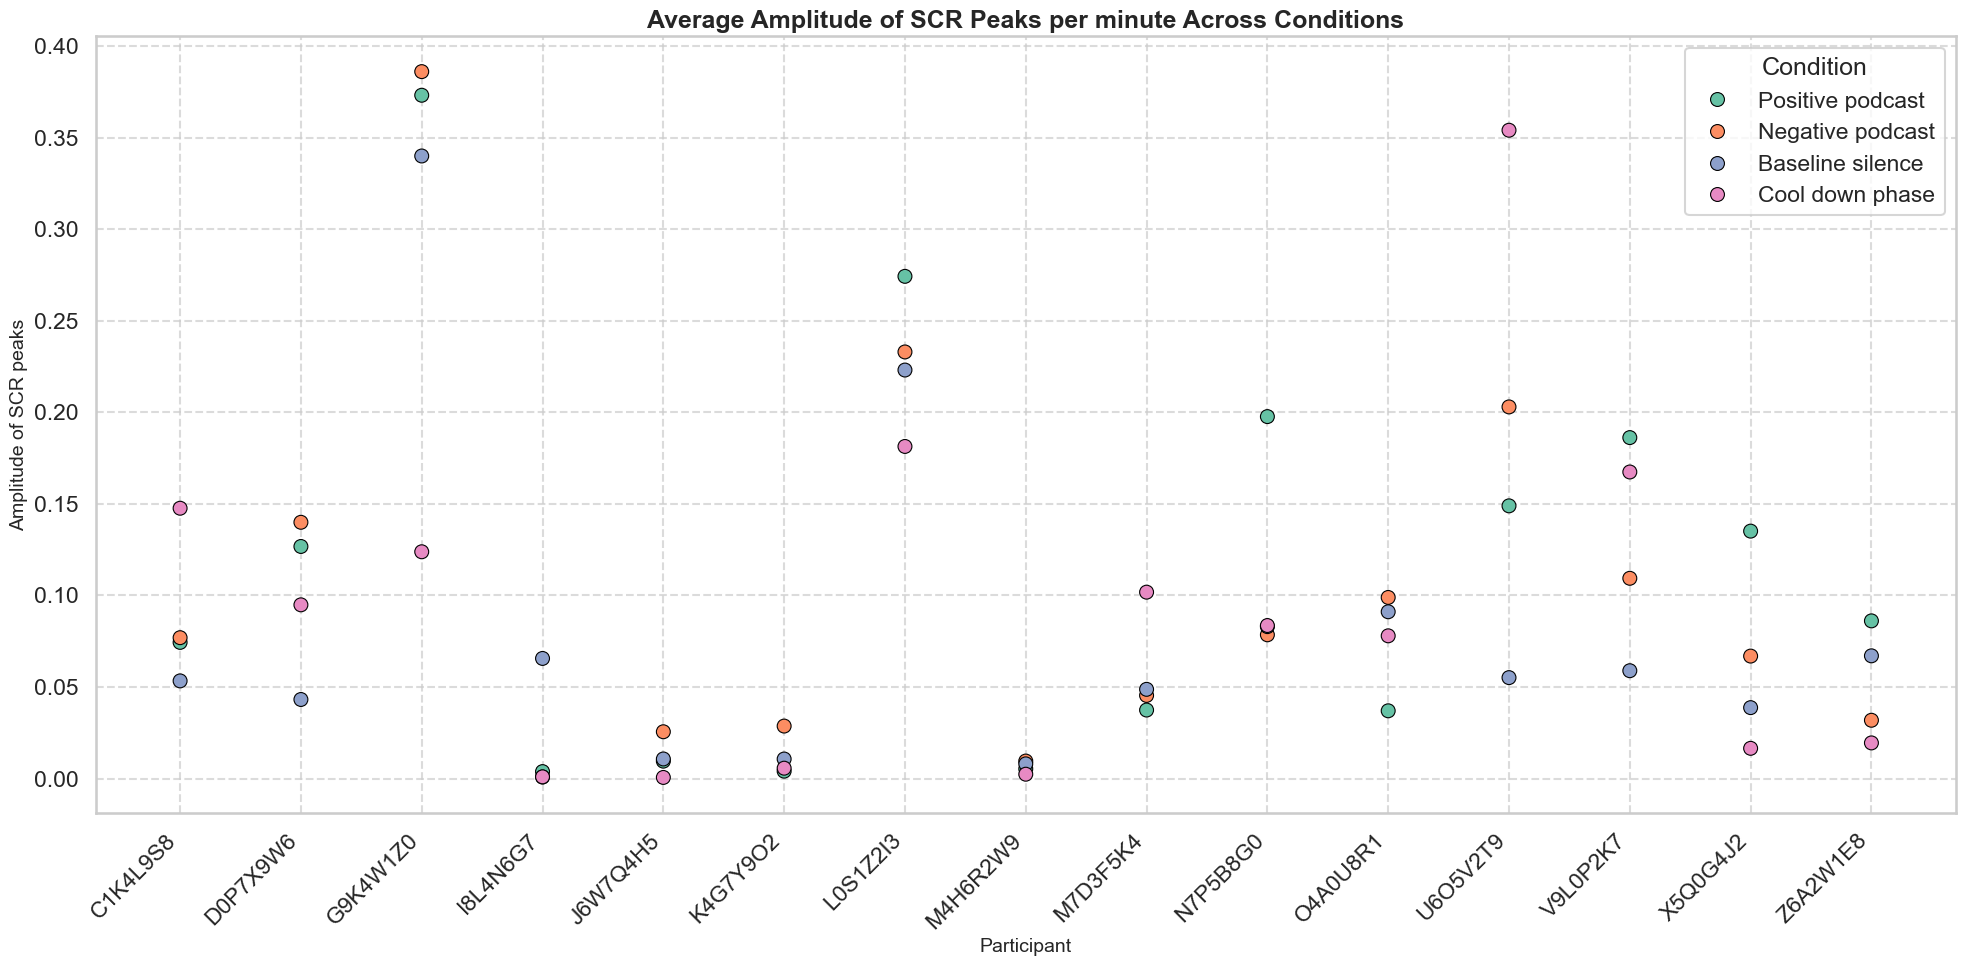

In [141]:
sns.set_style("whitegrid")
sns.set_context("talk")  


plt.figure(figsize=(20, 10))


sns.scatterplot(
    data=df_long,
    x="Participant",
    y="Amplitude of SCR peaks",
    hue="Condition",
    s=100,  # size of dots
    palette="Set2",  # or "colorblind", "deep", etc.
    edgecolor='black'
)


plt.title("Average Amplitude of SCR Peaks per minute Across Conditions", fontsize=18, weight='bold')
plt.xlabel("Participant", fontsize=14)
plt.ylabel("Amplitude of SCR peaks", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [142]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility
n_participants = len(n_peaks_pos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline silence': n_peaks_bas_1,  
    'Cool down phase': n_peaks_bas_2,  
    'Positive podcast': n_peaks_pos,
    'Negative podcast': n_peaks_neg
}
df = pd.DataFrame(data)


# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

print()


conditions = df.columns[1:]
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        cond1, cond2 = conditions[i], conditions[j]
        stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
        print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}")



Shapiro-Wilk test for Baseline silence: statistic=0.936, p=0.335
Shapiro-Wilk test for Cool down phase: statistic=0.713, p=0.000
  Cool down phase is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive podcast: statistic=0.907, p=0.122
Shapiro-Wilk test for Negative podcast: statistic=0.630, p=0.000
  Negative podcast is not normally distributed (p < 0.05)

Wilcoxon Baseline silence vs Cool down phase: statistic=57.000, p=0.890
Wilcoxon Baseline silence vs Positive podcast: statistic=33.000, p=0.135
Wilcoxon Baseline silence vs Negative podcast: statistic=37.000, p=0.191
Wilcoxon Cool down phase vs Positive podcast: statistic=39.000, p=0.252
Wilcoxon Cool down phase vs Negative podcast: statistic=37.000, p=0.208
Wilcoxon Positive podcast vs Negative podcast: statistic=55.000, p=0.804


/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_23013/2136741750.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Number of SCR peaks', data=df_long, palette=palette, width=0.5)


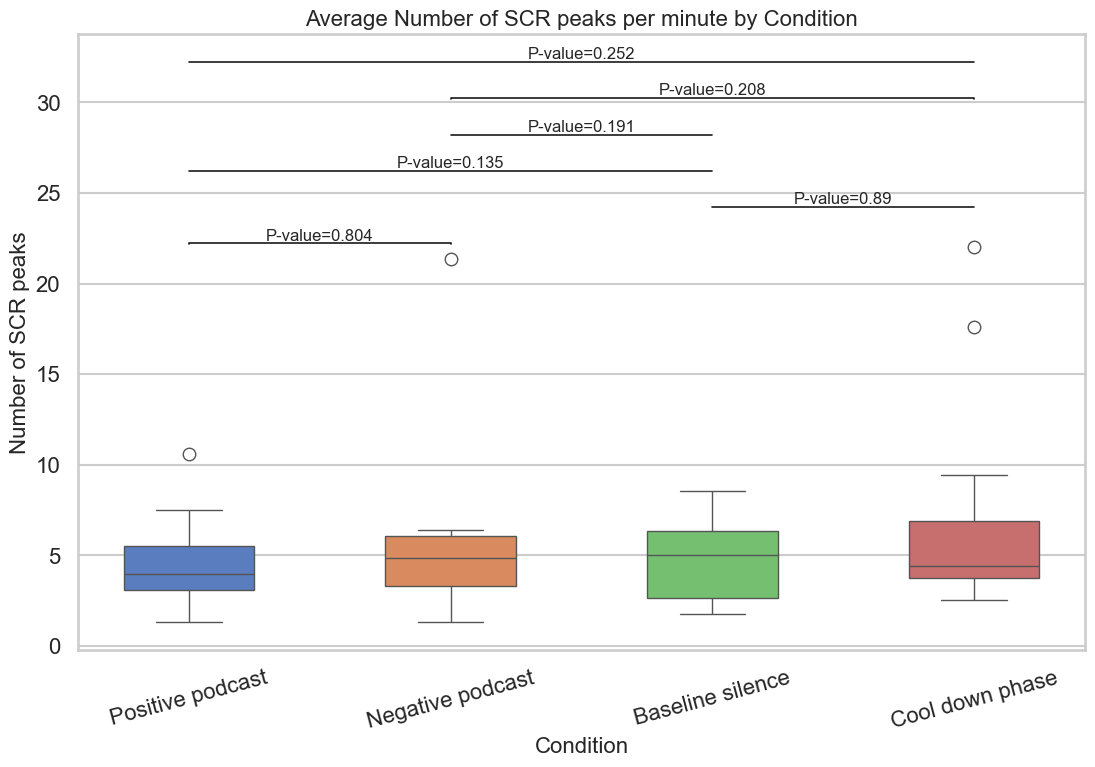

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

# Define custom colors
palette = sns.color_palette("muted", 4)  # or "muted", "pastel", "deep", etc.
plt.figure(figsize=(13, 8))
sns.boxplot(x='Condition', y='Number of SCR peaks', data=df_long, palette=palette, width=0.5)

comparisons = [
    ('Positive podcast', 'Negative podcast'),
    ('Baseline silence', 'Cool down phase'),
    ('Baseline silence', 'Positive podcast'),
    ('Baseline silence', 'Negative podcast'),
    ('Cool down phase', 'Negative podcast'),
    ('Cool down phase', 'Positive podcast'),
]

x_labels = df_long['Condition'].unique().tolist()

y_offset = 2
y_start = df_long['Number of SCR peaks'].max() + 0.2
h = 0.01
fontsize = 12

for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # P-value annotation
    label = f'P-value={round(p_val, 3)}'
    if p_val < 0.05:    
        plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize, fontweight='bold')
    else:
        plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Average Number of SCR peaks per minute by Condition', fontsize=16)
plt.ylabel('Number of SCR peaks', fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.xticks(fontsize=16,rotation=15)
plt.yticks(fontsize=16)
plt.show()


#### Tests for the mean amplitude of peaks

In [148]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility
n_participants = len(ampl_peaks_pos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline silence': ampl_peaks_bas_1,  
    'Cool down phase': ampl_peaks_bas_2,  
    'Positive podcast': ampl_peaks_pos,
    'Negative podcast': ampl_peaks_neg
}
df = pd.DataFrame(data)


# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

print()


conditions = df.columns[1:]
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        cond1, cond2 = conditions[i], conditions[j]
        stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
        print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}")



Shapiro-Wilk test for Baseline silence: statistic=0.690, p=0.000
  Baseline silence is not normally distributed (p < 0.05)
Shapiro-Wilk test for Cool down phase: statistic=0.849, p=0.017
  Cool down phase is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive podcast: statistic=0.890, p=0.068
Shapiro-Wilk test for Negative podcast: statistic=0.831, p=0.009
  Negative podcast is not normally distributed (p < 0.05)

Wilcoxon Baseline silence vs Cool down phase: statistic=60.000, p=1.000
Wilcoxon Baseline silence vs Positive podcast: statistic=29.000, p=0.083
Wilcoxon Baseline silence vs Negative podcast: statistic=28.000, p=0.073
Wilcoxon Cool down phase vs Positive podcast: statistic=40.000, p=0.277
Wilcoxon Cool down phase vs Negative podcast: statistic=53.000, p=0.720
Wilcoxon Positive podcast vs Negative podcast: statistic=56.000, p=0.847


/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_23013/91813986.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Amplitude of SCR peaks', data=df_long, palette=palette, width=0.5)


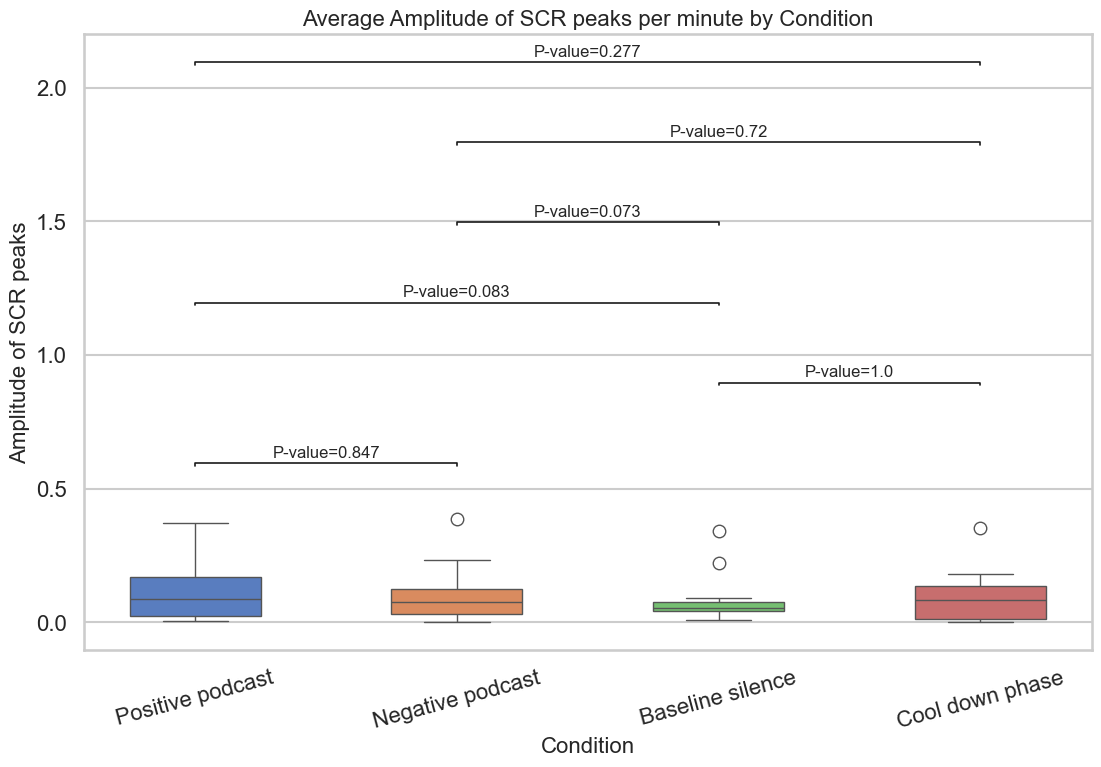

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

# Define custom colors
palette = sns.color_palette("muted", 4)  # or "muted", "pastel", "deep", etc.
plt.figure(figsize=(13, 8))
sns.boxplot(x='Condition', y='Amplitude of SCR peaks', data=df_long, palette=palette, width=0.5)

comparisons = [
    ('Positive podcast', 'Negative podcast'),
    ('Baseline silence', 'Cool down phase'),
    ('Baseline silence', 'Positive podcast'),
    ('Baseline silence', 'Negative podcast'),
    ('Cool down phase', 'Negative podcast'),
    ('Cool down phase', 'Positive podcast'),
]

x_labels = df_long['Condition'].unique().tolist()

y_offset = 0.3
y_start = df_long['Amplitude of SCR peaks'].max() + 0.2
h = 0.01
fontsize = 12

for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # P-value annotation
    label = f'P-value={round(p_val, 3)}'
    if p_val < 0.05:    
        plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize, fontweight='bold')
    else:
        plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Average Amplitude of SCR peaks per minute by Condition', fontsize=16)
plt.ylabel('Amplitude of SCR peaks', fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.xticks(fontsize=16,rotation=15)
plt.yticks(fontsize=16)
plt.show()


# EDA Empatica

## Combine timestamps

In [151]:
import warnings
warnings.filterwarnings('ignore')

In [152]:
df = pd.read_csv('/Users/annapalatkina/Desktop/drive/stress_output_eda_embracePlus.csv')
problematic = ['R0V9G1L4-3YK3K151PX'] #'L1N3B5O2-3YK3K151PX', 'G2Y7J4Q1-3YK3K151PX'
df = df.query('ParticipantID not in @problematic')
df['ParticipantID'].replace('V9LOP2K7-3YK3K151PX', 'V9L0P2K7-3YK3K151PX', inplace=True)

df

,ParticipantID,file_name,samplingFrequencyEDA,time_iso,EDA,detectedMOS,MOS_Score
0,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.171413+00:00,0.101990,0.0,0.0
1,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.421413+00:00,0.127179,0.0,0.0
2,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.671413+00:00,0.132416,0.0,0.0
3,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.921413+00:00,0.134792,0.0,0.0
4,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:55.171413+00:00,0.136614,0.0,0.0
...,...,...,...,...,...,...,...
145051,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.015978+00:00,0.957719,0.0,0.0
145052,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.265978+00:00,0.956452,0.0,0.0
145053,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.515978+00:00,0.954958,0.0,0.0
145054,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.765978+00:00,0.952368,0.0,0.0


In [154]:
len(df.ParticipantID.unique())

18

In [153]:
def get_experiment_start(path):

    with open(path, 'r+') as f:
        for line in f.readlines():
            if line.startswith('#Recording time'):
                timestamp_str = line.replace('#Recording time,Date: ', '')
                timestamp_str = timestamp_str[:timestamp_str.find(',Unix time:')]
                break

    try:
        ts = pd.to_datetime(timestamp_str,
                        format="%d.%m.%Y,Time: %H:%M:%S.%f +02:00")
    except:
        ts = pd.to_datetime(timestamp_str,
                            format="%m/%d/%Y,Time: %H:%M:%S.%f +02:00")
    ts = ts - timedelta(hours=2)
    nanoseconds = int(ts.value)
    return nanoseconds

In [161]:
folder_path = "/Users/annapalatkina/Desktop/drive/participants"  

data_full = pd.DataFrame(columns=['miliseconds', 'EDA',  'EventLabel', 'Participant', 'detectedMOS', 'MOS_Score'])

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv') and filename != 'N7P5B8G0.csv':   
        
        experiment_start_nanoseconds = get_experiment_start(file_path)
        participant_id = filename.split('.')[0]
        data_imotions = pd.read_csv(file_path, comment='#',low_memory=False, usecols=['Row','Timestamp','MarkerName','MarkerType'])
        participant_id_empatica = participant_id + '-3YK3K151PX'
        data_empatica = df.query('ParticipantID == @participant_id_empatica')
        
        data_empatica['miliseconds'] = [(pd.to_datetime(i).value - experiment_start_nanoseconds) / (10**6) for i in data_empatica['time_iso']]
        data_empatica = data_empatica.sort_values(by='miliseconds')

        start = data_imotions.query('MarkerName == "Experiment" and MarkerType == "S"').Timestamp.values[0]
        end = data_imotions.query('MarkerName == "Experiment" and MarkerType == "E"').Timestamp.values[0]
        data_empatica = data_empatica.query('@start <= miliseconds <= @end')

        markers = list(data_imotions[data_imotions['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data_empatica['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "S")].Timestamp.values[0]
            end = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "E")].Timestamp.values[0]
            idx = data_empatica.query('@start <= miliseconds <= @end').index
            data_empatica.loc[idx, 'EventLabel'] = data_empatica.loc[idx, 'EventLabel'].fillna(m)

        non_nan_indices = data_empatica['EventLabel'].notna()
        first_non_nan = non_nan_indices.idxmax() 
        last_non_nan = non_nan_indices[::-1].idxmax()

        data_empatica.loc[:first_non_nan-1, 'EventLabel'] = data_empatica.loc[:first_non_nan-1, 'EventLabel'].fillna('first_silence')
        data_empatica.loc[last_non_nan+1:, 'EventLabel'] = data_empatica.loc[last_non_nan+1:, 'EventLabel'].fillna('last_silence')

        data_empatica.drop(columns=['samplingFrequencyEDA', 'file_name', 'ParticipantID'], inplace=True)
        data_empatica['Participant'] = [participant_id] * len(data_empatica)
        data_full = pd.concat([data_full, data_empatica], ignore_index=True)
        del data_empatica
        gc.collect()

In [164]:
len(data_full.Participant.unique())

14

In [166]:
# we can add participants where we had problems with biopac, as they are not dependent

folder_path = "/Users/annapalatkina/Desktop/drive/participants/problematic"  

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv') and filename != 'R0V9G1L4.csv':   
        print(filename)
        
        experiment_start_nanoseconds = get_experiment_start(file_path)
        participant_id = filename.split('.')[0]
        data_imotions = pd.read_csv(file_path, comment='#',low_memory=False, usecols=['Row','Timestamp','MarkerName','MarkerType'])
        participant_id_empatica = participant_id + '-3YK3K151PX'
        data_empatica = df.query('ParticipantID == @participant_id_empatica')
        
        data_empatica['miliseconds'] = [(pd.to_datetime(i).value - experiment_start_nanoseconds) / (10**6) for i in data_empatica['time_iso']]
        data_empatica = data_empatica.sort_values(by='miliseconds')

        start = data_imotions.query('MarkerName == "Experiment" and MarkerType == "S"').Timestamp.values[0]
        end = data_imotions.query('MarkerName == "Experiment" and MarkerType == "E"').Timestamp.values[0]
        data_empatica = data_empatica.query('@start <= miliseconds <= @end')

        markers = list(data_imotions[data_imotions['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data_empatica['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "S")].Timestamp.values[0]
            end = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "E")].Timestamp.values[0]
            idx = data_empatica.query('@start <= miliseconds <= @end').index
            data_empatica.loc[idx, 'EventLabel'] = data_empatica.loc[idx, 'EventLabel'].fillna(m)

        non_nan_indices = data_empatica['EventLabel'].notna()
        first_non_nan = non_nan_indices.idxmax() 
        last_non_nan = non_nan_indices[::-1].idxmax()

        data_empatica.loc[:first_non_nan-1, 'EventLabel'] = data_empatica.loc[:first_non_nan-1, 'EventLabel'].fillna('first_silence')
        data_empatica.loc[last_non_nan+1:, 'EventLabel'] = data_empatica.loc[last_non_nan+1:, 'EventLabel'].fillna('last_silence')

        data_empatica.drop(columns=['samplingFrequencyEDA', 'file_name', 'ParticipantID'], inplace=True)
        data_empatica['Participant'] = [participant_id] * len(data_empatica)
        data_full = pd.concat([data_full, data_empatica], ignore_index=True)
        del data_empatica
        gc.collect()

M0R6U5F9.csv
L1N3B5O2.csv
G2Y7J4Q1.csv
J4X1T0D2.csv


In [168]:
len(data_full.Participant.unique())

18

In [169]:
data_full.EventLabel.value_counts()

EventLabel
IntenseAudio     19592
CalmAudio        19556
first_silence    15061
last_silence      6808
InterimAudio      3605
Name: count, dtype: int64

In [170]:
data_full.groupby('Participant').detectedMOS.sum()

Participant
C1K4L9S8     6.0
D0P7X9W6     6.0
G2Y7J4Q1     6.0
G9K4W1Z0     0.0
I8L4N6G7    22.0
J4X1T0D2    26.0
J6W7Q4H5    20.0
K4G7Y9O2    16.0
L0S1Z2I3    11.0
L1N3B5O2     1.0
M0R6U5F9    23.0
M4H6R2W9    26.0
M7D3F5K4     4.0
O4A0U8R1     1.0
U6O5V2T9     1.0
V9L0P2K7     8.0
X5Q0G4J2     1.0
Z6A2W1E8    10.0
Name: detectedMOS, dtype: float64

In [171]:
data_full.groupby('Participant').MOS_Score.sum()

Participant
C1K4L9S8     32.50
D0P7X9W6     98.75
G2Y7J4Q1    105.50
G9K4W1Z0     12.00
I8L4N6G7    280.75
J4X1T0D2    531.75
J6W7Q4H5    773.25
K4G7Y9O2    782.25
L0S1Z2I3    259.75
L1N3B5O2    126.00
M0R6U5F9    190.50
M4H6R2W9    630.25
M7D3F5K4     12.00
O4A0U8R1    125.50
U6O5V2T9     83.25
V9L0P2K7    351.50
X5Q0G4J2      2.50
Z6A2W1E8     78.00
Name: MOS_Score, dtype: float64

In [172]:
data_full.groupby('EventLabel').detectedMOS.sum()

EventLabel
CalmAudio        51.0
IntenseAudio     60.0
InterimAudio     10.0
first_silence    47.0
last_silence     20.0
Name: detectedMOS, dtype: float64

In [173]:
data_full.groupby('EventLabel').MOS_Score.sum()

EventLabel
CalmAudio        1294.25
IntenseAudio     1353.75
InterimAudio      196.25
first_silence    1160.75
last_silence      471.00
Name: MOS_Score, dtype: float64

In [174]:
sampling_rate = 4

In [201]:
mask_silence_first = (data_full["EventLabel"] == "first_silence")
mask_silence_last = (data_full["EventLabel"] == "last_silence")
mask_negative = (data_full["EventLabel"] == "IntenseAudio")
mask_positive = (data_full["EventLabel"] == "CalmAudio")
mask_music = (data_full["EventLabel"] == "InterimAudio")

In [202]:
positives = data_full[mask_positive]
negatives = data_full[mask_negative]
baselines_first = data_full[mask_silence_first]
baselines_last = data_full[mask_silence_last]

## Statistical tests for detectedMOS

In [203]:
# Normalize by minutes!!
positives_mos = np.array(positives.groupby('Participant').detectedMOS.sum())/average_time.CalmAudio
negatives_mos = np.array(negatives.groupby('Participant').detectedMOS.sum())/average_time.IntenseAudio
baselines_first = np.array(baselines_first.groupby('Participant').detectedMOS.sum())/average_time.first_silence
baselines_last = np.array(baselines_last.groupby('Participant').detectedMOS.sum())/average_time.last_silence

In [204]:
from scipy.stats import wilcoxon
res = wilcoxon(positives_mos, negatives_mos)
res.statistic, res.pvalue

(np.float64(52.0), np.float64(0.40725926237026755))

In [205]:
t = [i for i, _  in positives.groupby(by='Participant')]

# Create a tidy DataFrame
df_long = pd.DataFrame({
    "Participant": t * 4,
    "Number of MOS": list(positives_mos) + list(negatives_mos) + list(baselines_first) + list(baselines_last),
    "Condition": ["Positive podcast"] * len(t) + ["Negative podcast"] * len(t) + ["Baseline silence"] * len(t) + ["Cool down phase"] * len(t)
})

In [206]:
df_long

,Participant,Number of MOS,Condition
0,C1K4L9S8,0.000000,Positive podcast
1,D0P7X9W6,0.000000,Positive podcast
2,G2Y7J4Q1,0.220870,Positive podcast
3,G9K4W1Z0,0.000000,Positive podcast
4,I8L4N6G7,1.104349,Positive podcast
...,...,...,...
67,O4A0U8R1,0.000000,Cool down phase
68,U6O5V2T9,0.628700,Cool down phase
69,V9L0P2K7,0.000000,Cool down phase
70,X5Q0G4J2,0.000000,Cool down phase


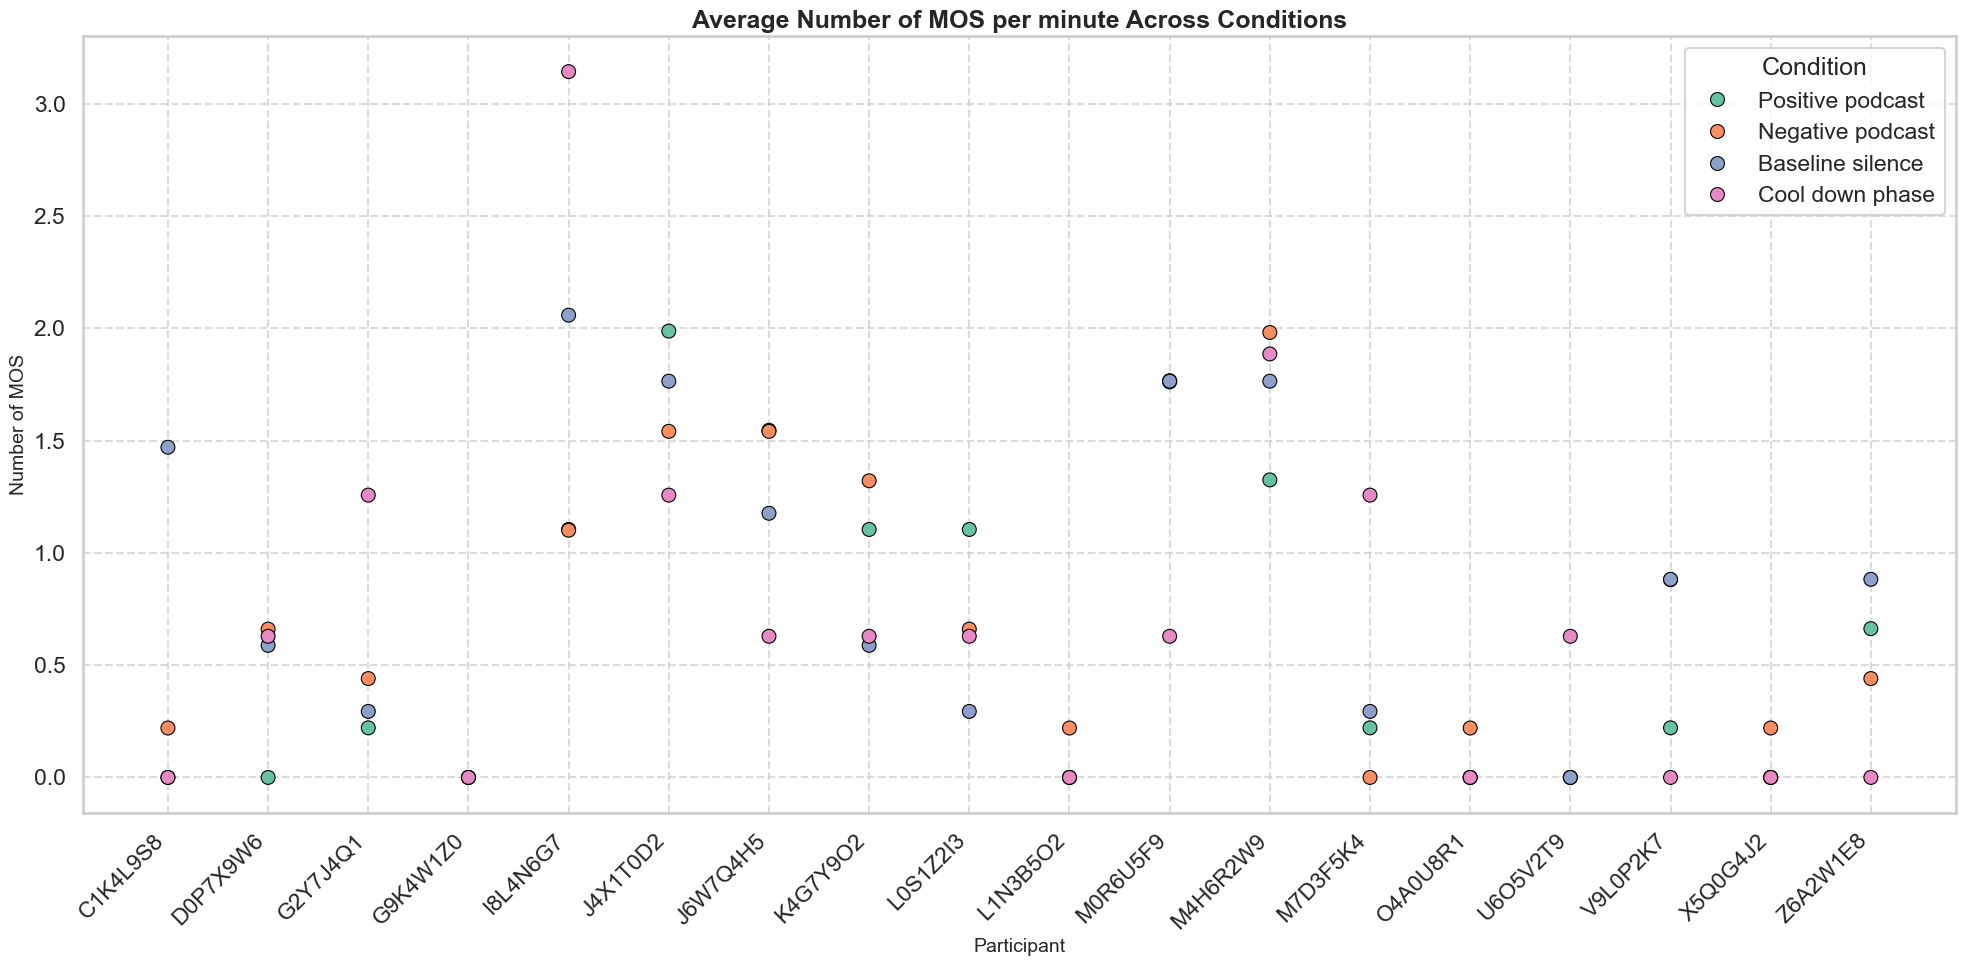

In [207]:
sns.set_style("whitegrid")
sns.set_context("talk")  


plt.figure(figsize=(20, 10))


sns.scatterplot(
    data=df_long,
    x="Participant",
    y="Number of MOS",
    hue="Condition",
    s=100,  # size of dots
    palette="Set2",  # or "colorblind", "deep", etc.
    edgecolor='black'
)


plt.title("Average Number of MOS per minute Across Conditions", fontsize=18, weight='bold')
plt.xlabel("Participant", fontsize=14)
plt.ylabel("Number of MOS", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [208]:
np.random.seed(42)  # For reproducibility
n_participants = len(positives_mos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline silence': baselines_first,  
    'Cool down phase': baselines_last, 
    'Positive podcast': positives_mos,
    'Negative podcast': negatives_mos
}
df = pd.DataFrame(data)

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

Shapiro-Wilk test for Baseline silence: statistic=0.872, p=0.020
  Baseline silence is not normally distributed (p < 0.05)
Shapiro-Wilk test for Cool down phase: statistic=0.792, p=0.001
  Cool down phase is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive podcast: statistic=0.823, p=0.003
  Positive podcast is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative podcast: statistic=0.896, p=0.049
  Negative podcast is not normally distributed (p < 0.05)


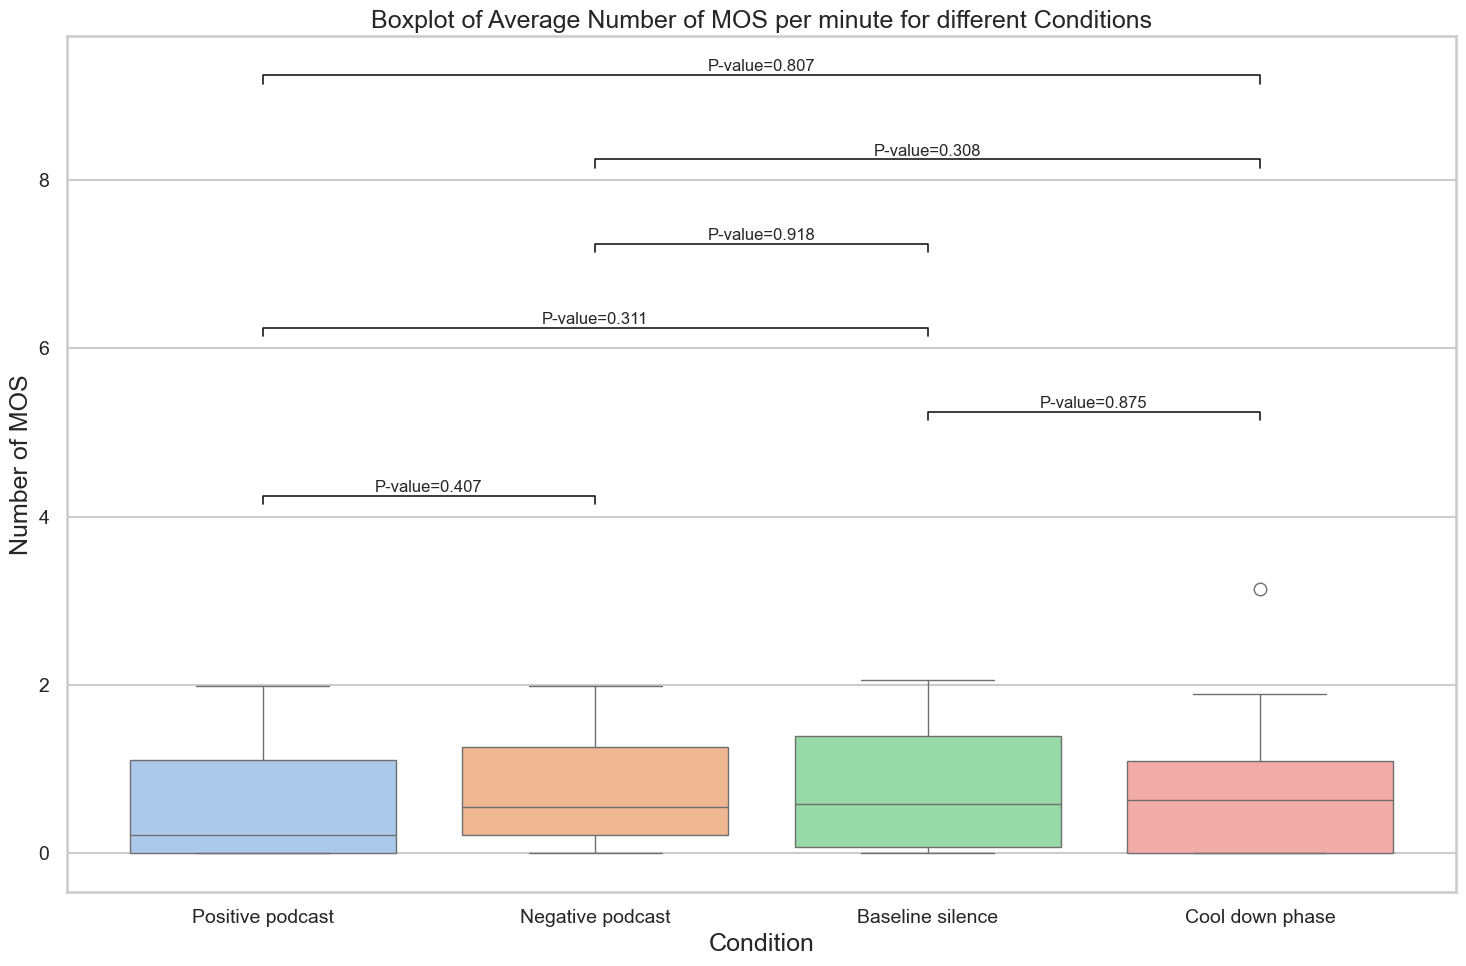

In [210]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='Condition', y='Number of MOS', data=df_long, palette='pastel')


comparisons = [
    ('Positive podcast', 'Negative podcast'),
    ('Baseline silence', 'Cool down phase'),
    ('Baseline silence', 'Positive podcast'),
    ('Baseline silence', 'Negative podcast'),
    ('Cool down phase', 'Negative podcast'),
    ('Cool down phase', 'Positive podcast'),
]


x_labels = df_long['Condition'].unique().tolist()


y_offset = 1
y_start = df_long['Number of MOS'].max() + 1  # Leave space above highest point
h = 0.1  # Height of bracket
fontsize = 12


for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # Text label
    label = f'P-value={round(p_val, 3)}'
    if p_val < 0.05:    
        plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize, fontweight='bold')
    else:
        plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Boxplot of Average Number of MOS per minute for different Conditions', fontsize=18)
plt.ylabel('Number of MOS', fontsize=18)
plt.xlabel('Condition', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


## Statistical tests for MOS_score

In [187]:
positives = data_full[mask_positive]
negatives = data_full[mask_negative]
baselines_first = data_full[mask_silence_first]
baselines_last = data_full[mask_silence_last]

In [188]:
positives_mos = np.array(positives.groupby('Participant').MOS_Score.mean())
negatives_mos = np.array(negatives.groupby('Participant').MOS_Score.mean())
baselines_first = np.array(baselines_first.groupby('Participant').MOS_Score.mean())
baselines_last = np.array(baselines_last.groupby('Participant').MOS_Score.mean())

In [189]:
from scipy.stats import wilcoxon
res = wilcoxon(positives_mos, negatives_mos)
res.statistic, res.pvalue

(np.float64(59.0), np.float64(0.2645263671875))

In [192]:
t = [i for i, _  in positives.groupby(by='Participant')]

# Create a tidy DataFrame
df_long = pd.DataFrame({
    "Participant": t * 4,
    "Mean MOS score": list(positives_mos) + list(negatives_mos) + list(baselines_first) + list(baselines_last),
    "Condition": ["Positive podcast"] * len(t) + ["Negative podcast"] * len(t) + ["Baseline silence"] * len(t) + ["Cool down phase"] * len(t)
})

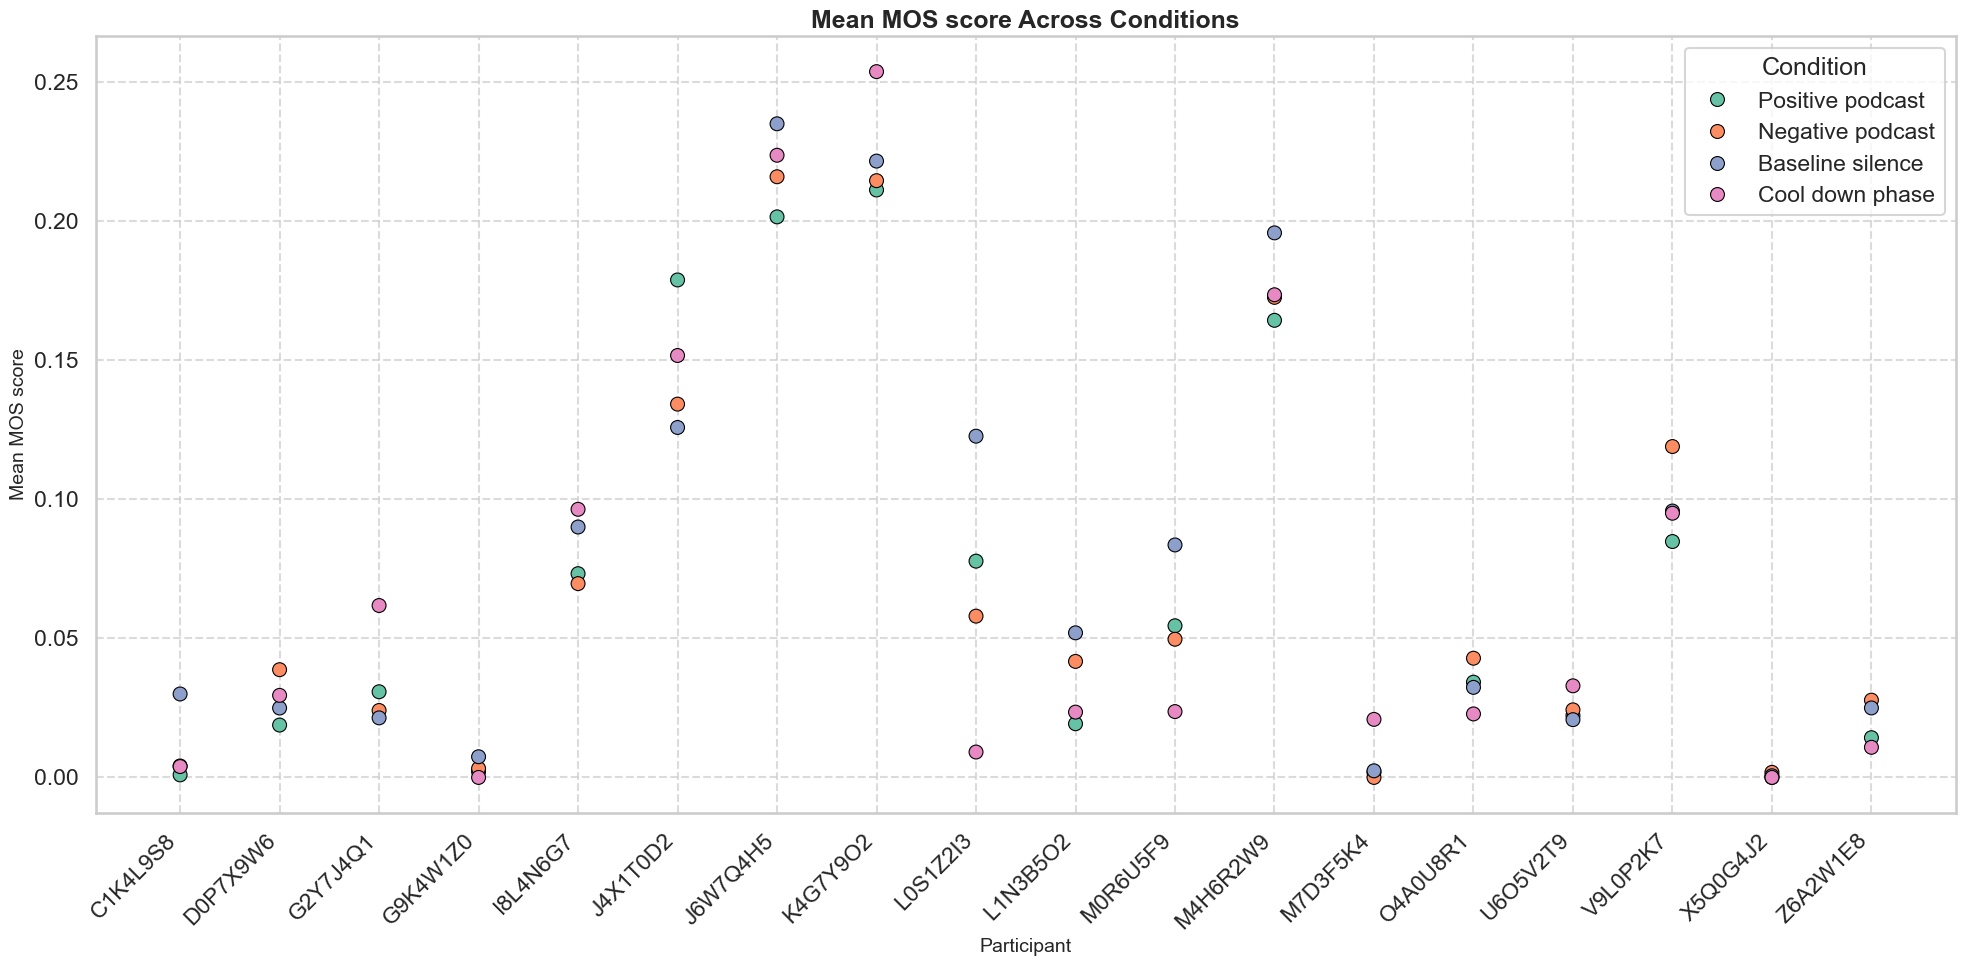

In [193]:
sns.set_style("whitegrid")
sns.set_context("talk")  


plt.figure(figsize=(20, 10))


sns.scatterplot(
    data=df_long,
    x="Participant",
    y="Mean MOS score",
    hue="Condition",
    s=100,  # size of dots
    palette="Set2",  # or "colorblind", "deep", etc.
    edgecolor='black'
)


plt.title("Mean MOS score Across Conditions", fontsize=18, weight='bold')
plt.xlabel("Participant", fontsize=14)
plt.ylabel("Mean MOS score", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [194]:
np.random.seed(42)  # For reproducibility
n_participants = len(positives_mos)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline silence': baselines_first,  
    'Cool down phase': baselines_last, 
    'Positive podcast': positives_mos,
    'Negative podcast': negatives_mos
}
df = pd.DataFrame(data)

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

Shapiro-Wilk test for Baseline silence: statistic=0.850, p=0.008
  Baseline silence is not normally distributed (p < 0.05)
Shapiro-Wilk test for Cool down phase: statistic=0.796, p=0.001
  Cool down phase is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive podcast: statistic=0.810, p=0.002
  Positive podcast is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative podcast: statistic=0.828, p=0.004
  Negative podcast is not normally distributed (p < 0.05)


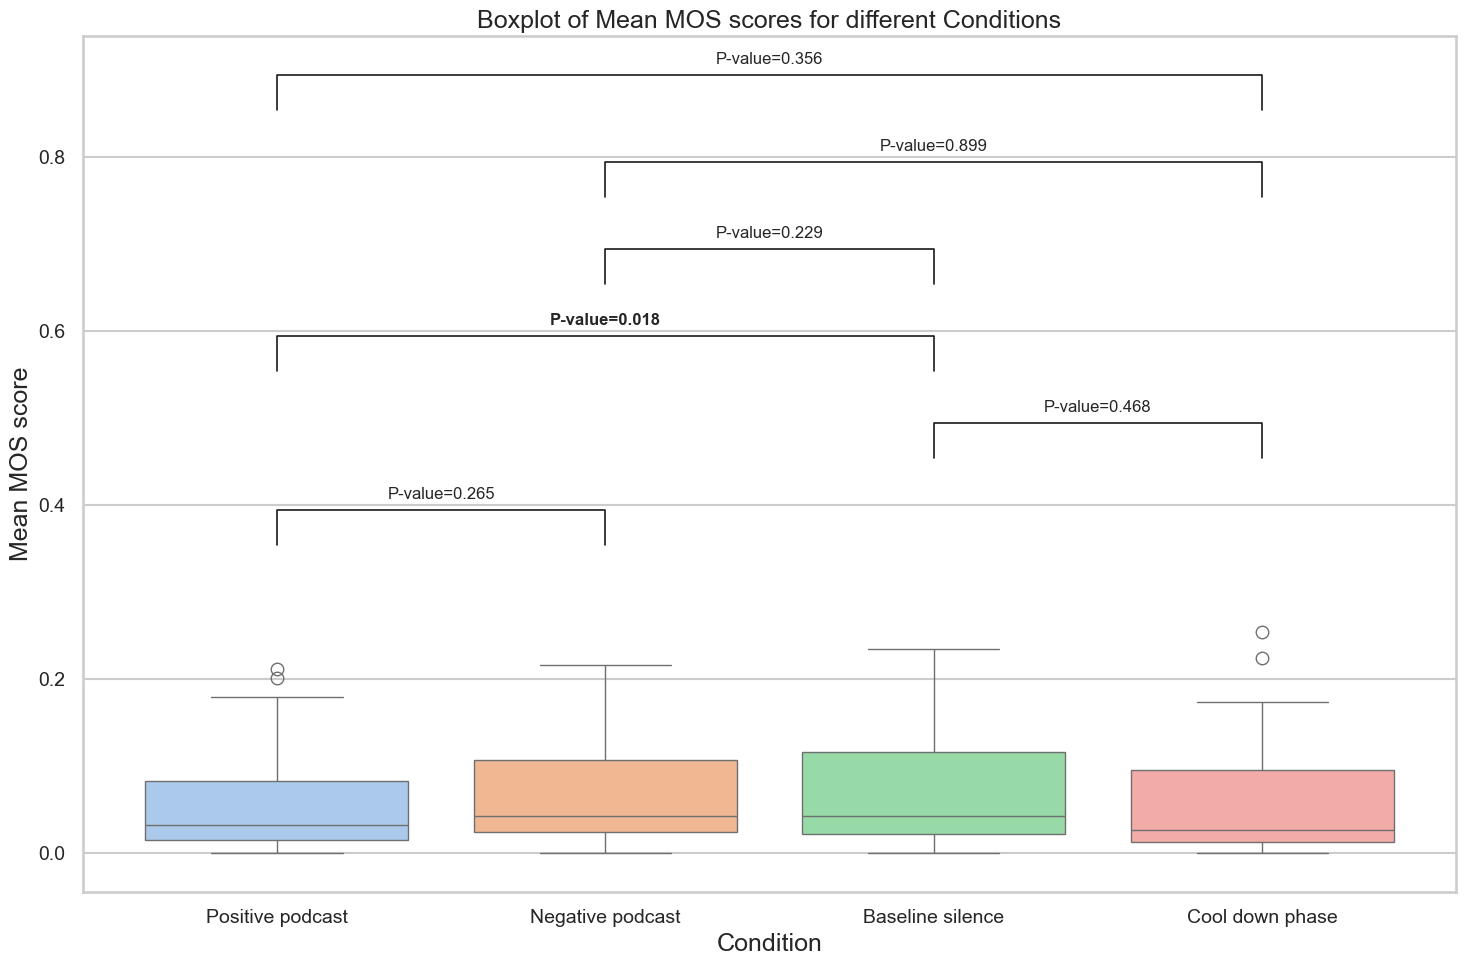

In [199]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='Condition', y='Mean MOS score', data=df_long, palette='pastel')


comparisons = [
    ('Positive podcast', 'Negative podcast'),
    ('Baseline silence', 'Cool down phase'),
    ('Baseline silence', 'Positive podcast'),
    ('Baseline silence', 'Negative podcast'),
    ('Cool down phase', 'Negative podcast'),
    ('Cool down phase', 'Positive podcast'),
]


x_labels = df_long['Condition'].unique().tolist()


y_offset = 0.1
y_start = df_long['Mean MOS score'].max() + 0.1  # Leave space above highest point
h = 0.04  # Height of bracket
fontsize = 12


for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # Text label
    label = f'P-value={round(p_val, 3)}'
    if p_val < 0.05:    
        plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize, fontweight='bold')
    else:
        plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)


# Final plot styling
plt.title('Boxplot of Mean MOS scores for different Conditions', fontsize=18)
plt.ylabel('Mean MOS score', fontsize=18)
plt.xlabel('Condition', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()
